# Census Data Compiler for Typology Map

This notebook was put together utilizing all of the different census variables to then create the typology for our Gentrification and Displacement Map

All of the data in this notebook is from compiled from different census tables located in the data folder on the repo. The data comes from Census years 2011 and 2016 from the Australian Bureau of Statistics.

### Education Analysis 
 - [Attainment of Bachelor's Degree or Higher, 2011 and 2016](#section1)
 - [Mapping Educational Attainment](#section1.1)
 
### Income Analysis 
 - [Total Household Income (Weekly), 2011 and 2016](#section2)
 - [Mapping Low-Income Household Distribution in 2011, 2016, and Change 2011-2016](#section2.1)
 
### Occupation Analysis 
 - [Occupation - Manager or Professional, 2011 and 2016](#section3)
 - [Mapping Occupation - Manager or Professional](#section3.1)
 
### Unemployment and Migration Analysis
- [Unemployment and Migration, 2011 and 2016](#section4)
- [Mapping Unemployment and Migration](#section4.1)

### Indigenous (Aboriginal Population) Analysis
- [Indigenous Populations, 2011 and 2016](#Section5)
- [Mapping Indigenous Populations](#section5.1)

### Rentals and Public Housing Analysis
- [Rentals and Public Housing, 2011 and 2016](#Section6)
- [Mapping Rental and Public Housing](#section6.1)

# Typology Creation

### [Map Generation](#Section7)

<a id="section1" ></a>
##  Attainment of Bachelor's Degree or Higher, 2011 and 2016

### Step 1: Import libraries, Import data, Get a clean dataframe

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
from datetime import datetime
from datetime import date
import statsmodels.api as sm
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#read in (2011) Table B40A: Non-School Qualification: Level of Education by Age by Sex
edu_b40a = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2011_census_files\\SA2_NSW\\2011Census_B40A_NSW_SA2_short.csv')

#read in (2011) Table B40B: Non-School Qualification: Level of Education by Age by Sex
edu_b40b = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2011_census_files\\SA2_NSW\\2011Census_B40B_NSW_SA2_short.csv')

#read in (2016) Table G46A: Non-School Qualification: Level of Education by Age by Sex
edu_g46a = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2016_census_files\\SA2_NSW\\2016Census_G46A_NSW_SA2.csv')

#read in G46B Table: Non-School Qualification: Level of Education by Age by Sex
edu_g46b = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2016_census_files\\SA2_NSW\\2016Census_G46B_NSW_SA2.csv')

#read in the correspondence file 2011<->2016
corr = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2011_2016_correspondence\\2011_2016_corr.csv')

### Cleaning 2011 Tables B40A and B40B

In [3]:
#keep only the total column for each edu level (not broken down m/f)
edu_b40a = edu_b40a[['region_id', 'P_PGrad_Deg_15_24', 'P_PGrad_Deg_25_34']]

#merge B40A and B40B into new dataframe: edu_11
edu_b40 = pd.merge(edu_b40a,edu_b40b,on='region_id',how="left").copy()

# rename "region_id" to "SA2_MAINCODE_2011" for SA2 ID to match 2016 and corr format
edu_b40.rename(columns={'region_id':'SA2_MAINCODE_2011'}, inplace=True)

#sum people age 25+ who earned a Bachelors, Grad, Postgrad

edu_b40['bach_25ov_11'] = edu_b40['P_BachDeg_25_34'] + edu_b40['P_BachDeg_35_44'] + edu_b40['P_BachDeg_45_54'] + edu_b40['P_BachDeg_55_64'] + edu_b40['P_BachDeg_65_74'] + edu_b40['P_BachDeg_75_84'] + edu_b40['P_BachDeg_85ov']
edu_b40['grad_25ov_11'] = edu_b40['P_GradDip_and_GradCert_25_34'] + edu_b40['P_GradDip_and_GradCert_35_44'] + edu_b40['P_GradDip_and_GradCert_45_54'] + edu_b40['P_GradDip_and_GradCert_55_64'] + edu_b40['P_GradDip_and_GradCert_65_74'] + edu_b40['P_GradDip_and_GradCert_75_84'] + edu_b40['P_GradDip_and_GradCert_85ov']
edu_b40['pgrad_25ov_11'] = edu_b40['P_PGrad_Deg_25_34'] + edu_b40['P_PGrad_Deg_35_44'] + edu_b40['P_PGrad_Deg_45_54'] + edu_b40['P_PGrad_Deg_55_64'] + edu_b40['P_PGrad_Deg_65_74'] + edu_b40['P_PGrad_Deg_75_84'] + edu_b40['P_PGrad_Deg_85ov']

#sum people age 25+ who earned a Bachelors degree or higher
edu_b40['bachplus_25ov_11'] = edu_b40['bach_25ov_11'] + edu_b40['grad_25ov_11'] + edu_b40['pgrad_25ov_11']

#sum the denominator of people age 25+
edu_b40['pop_25ov_11'] = edu_b40['P_Tot_25_34'] + edu_b40['P_Tot_35_44'] + edu_b40['P_Tot_45_54'] + edu_b40['P_Tot_55_64'] + edu_b40['P_Tot_65_74'] + edu_b40['P_Tot_75_84'] + edu_b40['P_Tot_85ov']

#restrict data frame to only the essentials
edu11 = edu_b40[['SA2_MAINCODE_2011', 'bachplus_25ov_11', 'pop_25ov_11']].copy()

### Correspondence: Fitting 2011 Data to 2016 Geographies

In [4]:
#merge many:many, joining income B40 table (NSW) to the correspondence table (all of Australia)
edu_2011 = pd.merge(edu11,corr,on='SA2_MAINCODE_2011',how='right')

#apply correspondence ration to 2011 data to fit to 2016 SA2 areas
edu_2011['bachplus_25ov_11_sa2'] = edu_2011['bachplus_25ov_11'] * edu_2011['RATIO']
edu_2011['pop_25ov_11_sa2'] = edu_2011['pop_25ov_11'] * edu_2011['RATIO']

# drop all null values from education table
edu_2011.dropna(inplace=True)

In [5]:
edu_2011_sa2 = edu_2011.copy()

### Cleaning 2016 Tables G46A and G46B

In [6]:
#keep only the total column for each edu level (not broken down m/f)
edu_g46a = edu_g46a[['SA2_MAINCODE_2016', 'P_PGrad_Deg_15_24', 'P_PGrad_Deg_25_34']]

#merge G46A and G46B into new dataframe: edu_g46
edu_g46 = pd.merge(edu_g46a,edu_g46b,on='SA2_MAINCODE_2016',how="left").copy()

#sum people age 25+ who earned a Bachelors, Grad, Postgrad
edu_g46['bach_25ov_16'] = edu_g46['P_BachDeg_25_34'] + edu_g46['P_BachDeg_35_44'] + edu_g46['P_BachDeg_45_54'] + edu_g46['P_BachDeg_55_64'] + edu_g46['P_BachDeg_65_74'] + edu_g46['P_BachDeg_75_84'] + edu_g46['P_BachDeg_85ov']
edu_g46['grad_25ov_16'] = edu_g46['P_GradDip_and_GradCert_25_34'] + edu_g46['P_GradDip_and_GradCert_35_44'] + edu_g46['P_GradDip_and_GradCert_45_54'] + edu_g46['P_GradDip_and_GradCert_55_64'] + edu_g46['P_GradDip_and_GradCert_65_74'] + edu_g46['P_GradDip_and_GradCert_75_84'] + edu_g46['P_GradDip_and_GradCert_85ov']
edu_g46['pgrad_25ov_16'] = edu_g46['P_PGrad_Deg_25_34'] + edu_g46['P_PGrad_Deg_35_44'] + edu_g46['P_PGrad_Deg_45_54'] + edu_g46['P_PGrad_Deg_55_64'] + edu_g46['P_PGrad_Deg_65_74'] + edu_g46['P_PGrad_Deg_75_84'] + edu_g46['P_PGrad_Deg_85ov']

#sum people age 25+ who earned a Bachelors degree or higher
edu_g46['bachplus_25ov_16'] = edu_g46['bach_25ov_16'] + edu_g46['grad_25ov_16'] + edu_g46['pgrad_25ov_16']

#sum the denominator of people age 25+
edu_g46['pop_25ov_16'] = edu_g46['P_Tot_25_34'] + edu_g46['P_Tot_35_44'] + edu_g46['P_Tot_45_54'] + edu_g46['P_Tot_55_64'] + edu_g46['P_Tot_65_74'] + edu_g46['P_Tot_75_84'] + edu_g46['P_Tot_85ov']

#restrict data frame to only the essentials

edu_2016 = edu_g46[['SA2_MAINCODE_2016', 'bachplus_25ov_16', 'pop_25ov_16']].copy()

### Merge 2011 and 2016 Tables

In [7]:
#merge 2011 and 2016 tables
education = pd.merge(edu_2011_sa2,edu_2016,on='SA2_MAINCODE_2016',how="right")
education

,SA2_MAINCODE_2011,bachplus_25ov_11,pop_25ov_11,SA2_NAME_2011,SA2_MAINCODE_2016,SA2_NAME_2016,RATIO,PERCENTAGE,bachplus_25ov_11_sa2,pop_25ov_11_sa2,bachplus_25ov_16,pop_25ov_16
0,101011001.0,1525.0,8126.0,Goulburn,101051539,Goulburn,1.00000,100.000000,1525.000000,8126.000000,1947,9795
1,101011002.0,1078.0,4730.0,Goulburn Region,101051540,Goulburn Region,1.00000,100.000000,1078.000000,4730.000000,1282,5803
2,101011003.0,675.0,2501.0,Yass,101061541,Yass,1.00000,100.000000,675.000000,2501.000000,837,2872
3,101011004.0,1951.0,4736.0,Yass Region,101061542,Yass Region,1.00000,100.000000,1951.000000,4736.000000,2354,5654
4,113031264.0,209.0,1138.0,Gundagai,101061542,Yass Region,0.00035,0.034956,0.073066,0.397845,2354,5654
...,...,...,...,...,...,...,...,...,...,...,...,...
586,128021536.0,3761.0,9777.0,Oyster Bay - Como - Jannali,128021536,Oyster Bay - Como - Jannali,1.00000,100.000000,3761.000000,9777.000000,4466,10482
587,128021537.0,3.0,9.0,Royal National Park,128021537,Royal National Park,1.00000,100.000000,3.000000,9.000000,4,14
588,128021538.0,3137.0,9487.0,Sutherland - Kirrawee,128021538,Sutherland - Kirrawee,1.00000,100.000000,3137.000000,9487.000000,4088,10811
589,199999499.0,1540.0,6414.0,No usual address (NSW),199999499,No usual address (NSW),1.00000,100.000000,1540.000000,6414.000000,1521,6754


### Merge SA2 shapes for UCL area

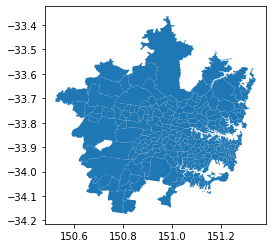

In [8]:
syd_ucl = gpd.read_file('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\SA2 Shapefiles\\sa2_ucl.dbf')
syd_ucl['SA2_MAIN16']=syd_ucl['SA2_MAIN16'].astype(int)
syd_ucl.plot()

In [9]:
#merge 2011 and 2016 income data with UCL SA2 data
edu_11_16 = pd.merge(syd_ucl, education, left_on='SA2_MAIN16', right_on='SA2_MAINCODE_2016', how='left').copy()
edu_11_16.head()

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry,SA2_MAINCODE_2011,bachplus_25ov_11,pop_25ov_11,SA2_NAME_2011,SA2_MAINCODE_2016,SA2_NAME_2016,RATIO,PERCENTAGE,bachplus_25ov_11_sa2,pop_25ov_11_sa2,bachplus_25ov_16,pop_25ov_16
0,115011290,11290,Baulkham Hills (East),11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,8.3081,"POLYGON ((150.97069 -33.75928, 150.97071 -33.7...",115011290.0,4645.0,10208.0,Baulkham Hills (East),115011290,Baulkham Hills (East),1.000000,100.000000,4645.000000,10208.000000,6022,11635
1,115011291,11291,Baulkham Hills (West) - Bella Vista,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,10.9631,"POLYGON ((150.94715 -33.74089, 150.94704 -33.7...",115011291.0,3971.0,8359.0,Baulkham Hills (West) - Bella Vista,115011291,Baulkham Hills (West) - Bella Vista,1.000000,100.000000,3971.000000,8359.000000,5369,9900
2,115011294,11294,Glenhaven,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,7.2309,"POLYGON ((150.98461 -33.70294, 150.98468 -33.7...",115011294.0,1147.0,2675.0,Glenhaven,115011294,Glenhaven,1.000000,99.999983,1146.999771,2674.999465,1388,3130
3,115011296,11296,West Pennant Hills,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,7.8291,"POLYGON ((151.02214 -33.73881, 151.02214 -33.7...",115011296.0,3525.0,6154.0,West Pennant Hills,115011296,West Pennant Hills,1.000000,100.000000,3525.000000,6154.000000,4125,6664
4,115011553,11553,Castle Hill - Central,11501,Baulkham Hills,115,Sydney - Baulkham Hills and Hawkesbury,1GSYD,Greater Sydney,1,New South Wales,4.1512,"POLYGON ((150.97343 -33.73437, 150.97332 -33.7...",115011292.0,6459.0,13308.0,Castle Hill,115011553,Castle Hill - Central,0.262683,26.268300,1696.669497,3495.785364,2149,3928


### Calculate Percents and Percent Change, 2011 to 2016

In [10]:
#calculate % residents 25+ with a bachelors degree or higher

edu_11_16['bachplus_11_pct'] = edu_11_16['bachplus_25ov_11_sa2']/edu_11_16['pop_25ov_11_sa2']
edu_11_16['bachplus_16_pct'] = edu_11_16['bachplus_25ov_16']/edu_11_16['pop_25ov_16']

#determine what % of people 25+ in median SA2 has Bach or higher in 2011 (answer: 39.5950%)
print(edu_11_16['bachplus_11_pct'].describe(percentiles=[.2,.4,.6,.8]))

#dummy variable for SA2s where % people w Bach+ < regional median (39.5950%) 2011
edu_11_16['bachplus_11_pct_ovregmed'] = np.where(edu_11_16['bachplus_11_pct'] < 0.395950, 1, 0)

#determine what % of people 25+ in median SA2 has Bach or higher in 2016 (answer: 44.4075%)
print(edu_11_16['bachplus_16_pct'].describe())

#dummy variable for SA2s where % people w Bach+ < regional median (44.4075%) 2016
edu_11_16['bachplus_16_pct_ovregmed'] = np.where(edu_11_16['bachplus_16_pct'] < 0.444075, 1, 0)

#calculate difference in percent
#subtract: [2016 % of people Age 25+ with Bach+] minus [2011 % of people Age 25+ with Bach+]
edu_11_16['pdiff_bachplus'] =  (edu_11_16['bachplus_16_pct']) - (edu_11_16['bachplus_11_pct'])

#calculate percent change
#divide: [percent difference] / [2011 %]
edu_11_16['pchg_pct_bachplus'] = (edu_11_16['pdiff_bachplus'])/(edu_11_16['bachplus_11_pct'])

#determine what % change in people 25+ has Bach+ in median SA2 (answer: 11.6197%)
print(edu_11_16['pchg_pct_bachplus'].describe(percentiles=[.2,.4,.6,.8]))

#dummy variable for SA2s where % change in SA2 share people age25+ with Bach+ > regional median (11.6197%)
edu_11_16['pchg_pct_bachplus_ovregmed'] = np.where(edu_11_16["pchg_pct_bachplus"] > 0.116197, 1, 0)

count    267.000000
mean       0.401343
std        0.153057
min        0.000000
20%        0.264123
40%        0.340623
50%        0.394324
60%        0.447678
80%        0.552338
max        1.000000
Name: bachplus_11_pct, dtype: float64
count    266.000000
mean       0.441002
std        0.151726
min        0.000000
25%        0.336057
50%        0.443751
75%        0.572817
max        0.708386
Name: bachplus_16_pct, dtype: float64
count    266.000000
mean            inf
std             NaN
min       -1.000000
20%        0.060408
40%        0.101381
50%        0.116000
60%        0.138109
80%        0.190632
max             inf
Name: pchg_pct_bachplus, dtype: float64


### Map Bachelors Education+ Distribution in 2011, 2016, and Change 2011-2016

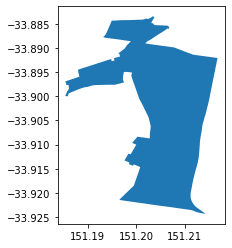

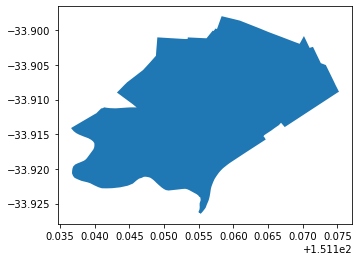

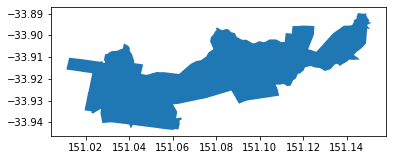

In [11]:
edu_map = edu_11_16

# let's isolate the sa2s that make up Redfern/Waterloo
red_wat_gdf = edu_map[(edu_map.SA2_MAIN16==117031335)
                          |(edu_map.SA2_MAIN16==117031338)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
red_wat_simple = red_wat_gdf[['SA2_MAIN16','geometry', "SA4_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
red_wat_sgdf=red_wat_simple.dissolve(by="SA4_NAME16")
red_wat_sgdf.plot()

# let's isolate the sa2s that make up Marrickville
marr_gdf = edu_map[(edu_map.SA2_MAIN16==117021326)]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
marr_simple = marr_gdf[['SA2_MAIN16','geometry', "SA4_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
marr_sgdf=marr_simple.dissolve(by="SA4_NAME16")
marr_sgdf.plot()

# let's isolate the sa2s that make up our case study areas of Sydenham to Bankstown
t3_corr_gdf = edu_map[(edu_map.SA2_MAIN16==120031394)
                          |(edu_map.SA2_MAIN16==120031392)
                          |(edu_map.SA2_MAIN16==119021363)
                          |(edu_map.SA2_MAIN16==119021362)
                          |(edu_map.SA2_MAIN16==119021573)
                          |(edu_map.SA2_MAIN16==119021574)
                          |(edu_map.SA2_MAIN16==119021366)
                          |(edu_map.SA2_MAIN16==119011572)
                          |(edu_map.SA2_MAIN16==119011571)].copy()

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
t3_corr_simple = t3_corr_gdf[['SA2_MAIN16','geometry', "GCC_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
t3_corr_sgdf=t3_corr_simple.dissolve(by="GCC_NAME16")
t3_corr_sgdf.plot()

<a id="section1.1" ></a>
### Education Maps 

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


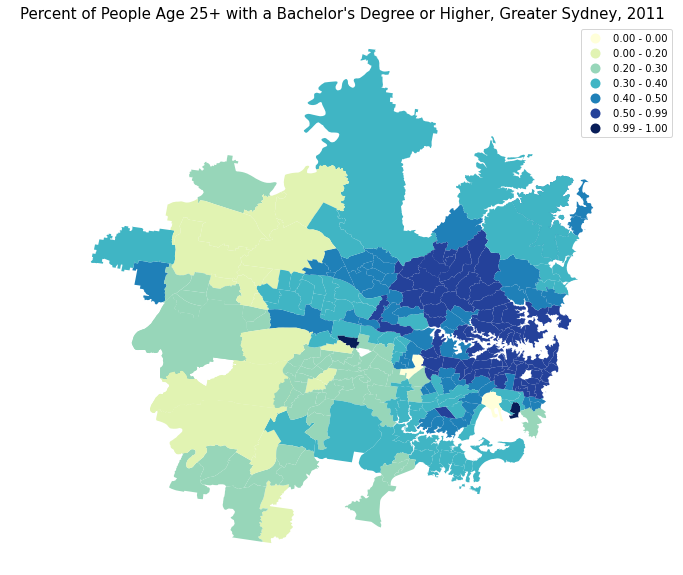

In [12]:
figure, ax = plt.subplots(figsize=(12,10))

base = edu_map.plot(column="bachplus_11_pct", 
                    scheme='user_defined', 
                    classification_kwds={'bins':[0,0.2, 0.3, 0.4, 0.5,0.99,1]}, 
                    legend=True, 
                    ax=ax, 
                    cmap="YlGnBu");

ax.set_title("Percent of People Age 25+ with a Bachelor's Degree or Higher, Greater Sydney, 2011", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off();

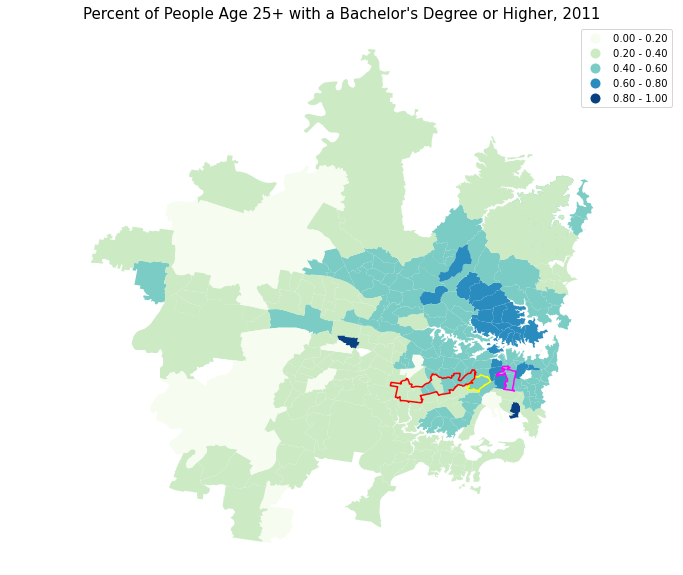

In [13]:
figure, ax = plt.subplots(figsize=(12,10))
base = edu_map.plot(column="bachplus_11_pct", 
                    scheme='user_defined', 
                    classification_kwds={'bins':[0.2, 0.4, 0.6,0.8]}, 
                    legend=True, 
                    ax=ax, 
                    cmap="GnBu")

ax.set_title("Percent of People Age 25+ with a Bachelor's Degree or Higher, 2011", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "red", linewidth = 1.5)

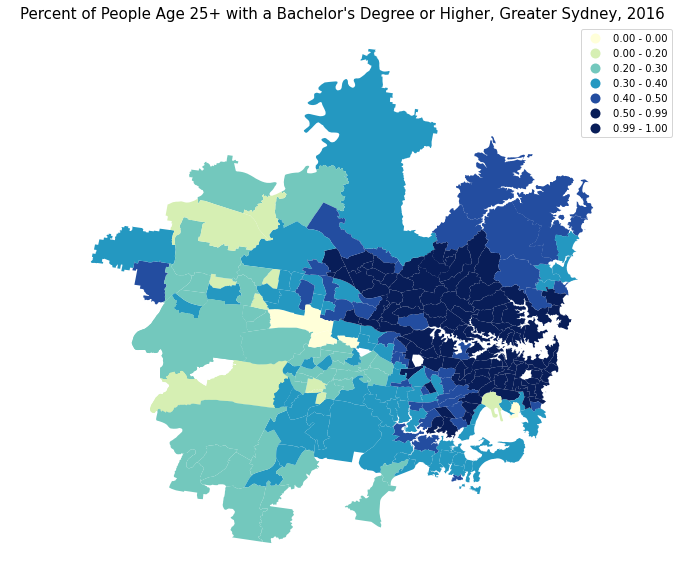

In [14]:
figure, ax = plt.subplots(figsize=(12,10))
base = edu_map.plot(column="bachplus_16_pct", 
                    scheme='user_defined', 
                    classification_kwds={'bins':[0,0.2, 0.3, 0.4, 0.5,0.99,1]}, 
                    legend=True, 
                    ax=ax, 
                    cmap="YlGnBu")

ax.set_title("Percent of People Age 25+ with a Bachelor's Degree or Higher, Greater Sydney, 2016", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

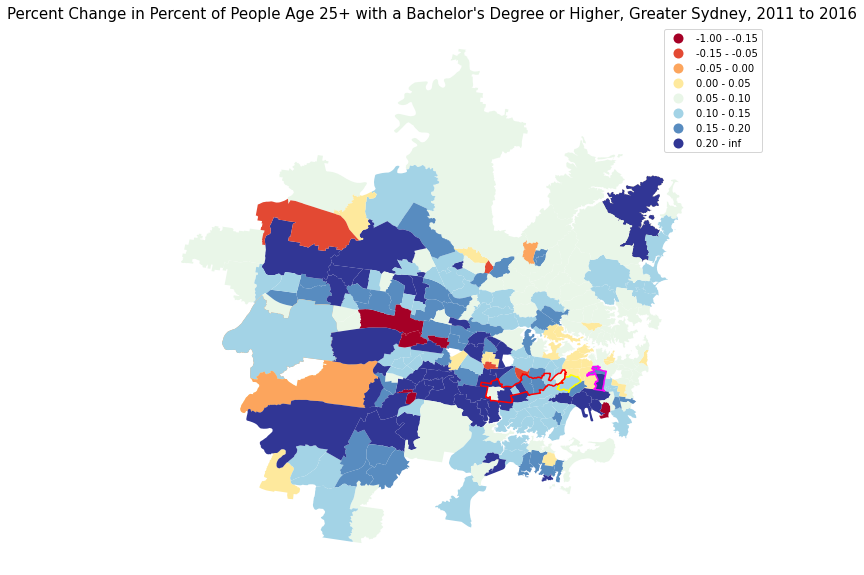

In [15]:
figure, ax = plt.subplots(figsize=(12,10))
base = edu_map.plot(column="pchg_pct_bachplus", 
                    scheme='user_defined', 
                    classification_kwds={'bins':[-0.15,-0.05,0,0.05,0.1,0.15,0.2]}, 
                    legend=True, ax=ax, cmap="RdYlBu");
ax.set_title("Percent Change in Percent of People Age 25+ with a Bachelor's Degree or Higher, Greater Sydney, 2011 to 2016", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "red", linewidth = 1.5);

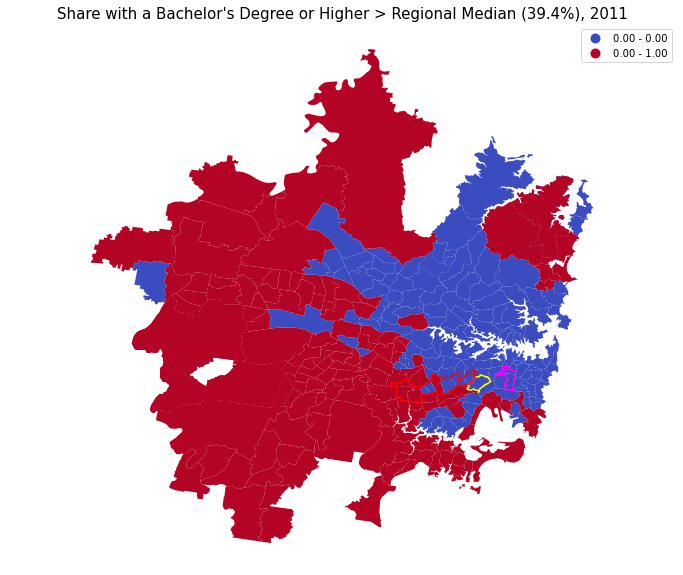

In [16]:
figure, ax = plt.subplots(figsize=(12,10))
base = edu_map.plot(column="bachplus_11_pct_ovregmed", 
                    scheme = "fisher_jenks", 
                    k = 2, legend=True, 
                    ax=ax, cmap="coolwarm")

ax.set_title("Share with a Bachelor's Degree or Higher > Regional Median (39.4%), 2011", fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "red", linewidth = 1.5);

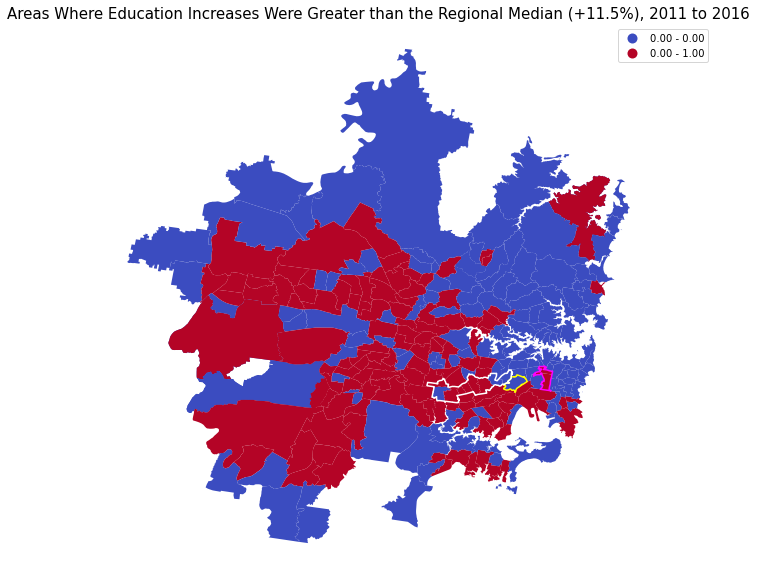

In [17]:
figure, ax = plt.subplots(figsize=(12,10))
base = edu_map.plot(column="pchg_pct_bachplus_ovregmed", 
                    scheme = "fisher_jenks", 
                    k = 2, legend=True, ax=ax, 
                    cmap="coolwarm")

ax.set_title("Areas Where Education Increases Were Greater than the Regional Median (+11.5%), 2011 to 2016", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "white", linewidth = 1.5);

<a id="section2" ></a>
## Total Household Income (Weekly), 2011 and 2016

In [18]:
#read in B28 Table (2011): Total Household Income (Weekly) by Household Composition
inc_b28 = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2011_census_files\\SA2_NSW\\2011Census_B28_NSW_SA2_short.csv')

#read in G29 Table (2016): Total Household Income (Weekly) by Household Composition
inc_g29 = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2016_census_files\\SA2_NSW\\2016Census_G29_NSW_SA2.csv')

##### Clean table g29

In [19]:
#keep only the total column for each household income range (not broken down fam/nonfam)
inc_g29 = inc_g29[['SA2_MAINCODE_2016', 'Negative_Nil_income_Tot', 'HI_1_149_Tot', 'HI_150_299_Tot', 
                   'HI_300_399_Tot', 'HI_400_499_Tot', 'HI_500_649_Tot', 'HI_650_799_Tot', 
                   'HI_800_999_Tot', 'HI_1000_1249_Tot', 'HI_1250_1499_Tot', 'HI_1500_1749_Tot', 
                   'HI_1750_1999_Tot', 'HI_2000_2499_Tot', 'HI_2500_2999_Tot', 'HI_3000_3499_Tot', 
                   'HI_3500_3999_Tot', 'HI_4000_more_Tot', 'Partial_income_stated_Tot', 
                   'All_incomes_not_stated_Tot', 'Tot_Tot']]

#rename columns with yr to facilitate merge
inc_g29.rename(columns={'Negative_Nil_income_Tot':'h16_neg_nil',
                        'HI_1_149_Tot':'h16_1_149', 
                        'HI_150_299_Tot':'h16_150_299',
                        'HI_300_399_Tot':'h16_300_399', 
                        'HI_400_499_Tot':'h16_400_499', 
                        'HI_500_649_Tot':'h16_500_649', 
                        'HI_650_799_Tot':'h16_650_799',
                        'HI_800_999_Tot':'h16_800_999', 
                        'HI_1000_1249_Tot':'h16_1000_1249', 
                        'HI_1250_1499_Tot':'h16_1250_1499', 
                        'HI_1500_1749_Tot':'h16_1500_1749', 
                        'HI_1750_1999_Tot':'h16_1750_1999', 
                        'HI_2000_2499_Tot':'h16_2000_2499', 
                        'HI_2500_2999_Tot':'h16_2500_2999', 
                        'HI_3000_3499_Tot':'h16_3000_3499', 
                        'HI_3500_3999_Tot':'h16_3500_3999', 
                        'HI_4000_more_Tot':'h16_4000_more', 
                        'Partial_income_stated_Tot':'h16_partial_rptd', 
                        'All_incomes_not_stated_Tot':'h16_allnot_rptd',
                        'Tot_Tot':'h16_count_total'}, inplace=True)

##### Clean Table G28

In [20]:
#keep only the total column for each household income range (not broken down fam/nonfam)

inc_b28 = inc_b28[['region_id', 'Negative_Nil_income_Tot', 'HI_1_199_Tot', 'HI_200_299_Tot', 'HI_300_399_Tot', 
                   'HI_400_599_Tot', 'HI_600_799_Tot', 'HI_800_999_Tot', 'HI_1000_1249_Tot', 'HI_1250_1499_Tot', 
                   'HI_1500_1999_Tot', 'HI_2000_2499_Tot', 'HI_2500_2999_Tot', 'HI_3000_3499_Tot', 
                   'HI_3500_3999_Tot', 'HI_4000_more_Tot', 'Partial_income_stated_Tot', 'All_incomes_not_stated_Tot', 
                   'Tot_Tot']]

#rename "region_id" to "SA2_MAINCODE_2011" for SA2 ID to match 2016 and corr format
inc_b28.rename(columns={'region_id':'SA2_MAINCODE_2011'}, inplace=True)

#rename columns with yr to facilitate merge
inc_b28.rename(columns={'Negative_Nil_income_Tot':'h11_neg_nil',
                        'HI_1_199_Tot':'h11_1_199', 
                        'HI_200_299_Tot':'h11_200_299',
                        'HI_300_399_Tot':'h11_300_399', 
                        'HI_400_599_Tot':'h11_400_599', 
                        'HI_600_799_Tot':'h11_600_799',
                        'HI_800_999_Tot':'h11_800_999', 
                        'HI_1000_1249_Tot':'h11_1000_1249', 
                        'HI_1250_1499_Tot':'h11_1250_1499', 
                        'HI_1500_1999_Tot':'h11_1500_1999',
                        'HI_2000_2499_Tot':'h11_2000_2499', 
                        'HI_2500_2999_Tot':'h11_2500_2999', 
                        'HI_3000_3499_Tot':'h11_3000_3499', 
                        'HI_3500_3999_Tot':'h11_3500_3999', 
                        'HI_4000_more_Tot':'h11_4000_more', 
                        'Partial_income_stated_Tot':'h11_partial_rptd', 
                        'All_incomes_not_stated_Tot':'h11_allnot_rptd',
                        'Tot_Tot':'h11_count_total'}, inplace=True)

### Correspondence: Fitting 2011 Data to 2016 Geographies

In [21]:
#merge many:many, joining income B28 table (NSW) to the correspondence table (all of Australia)
inc_2011 = pd.merge(inc_b28,corr,on='SA2_MAINCODE_2011',how='right')

In [22]:
#apply correspondence ratio to 2011 data to fit to 2016 SA2 areas
inc_2011['h11_neg_nil_sa2'] = inc_2011['h11_neg_nil'] * inc_2011['RATIO']
inc_2011['h11_1_199_sa2'] = inc_2011['h11_1_199'] * inc_2011['RATIO']
inc_2011['h11_200_299_sa2'] = inc_2011['h11_200_299'] * inc_2011['RATIO']
inc_2011['h11_300_399_sa2'] = inc_2011['h11_300_399'] * inc_2011['RATIO']
inc_2011['h11_400_599_sa2'] = inc_2011['h11_400_599'] * inc_2011['RATIO']
inc_2011['h11_600_799_sa2'] = inc_2011['h11_600_799'] * inc_2011['RATIO']
inc_2011['h11_800_999_sa2'] = inc_2011['h11_800_999'] * inc_2011['RATIO']
inc_2011['h11_1000_1249_sa2'] = inc_2011['h11_1000_1249'] * inc_2011['RATIO']
inc_2011['h11_1250_1499_sa2'] = inc_2011['h11_1250_1499'] * inc_2011['RATIO']
inc_2011['h11_1500_1999_sa2'] = inc_2011['h11_1500_1999'] * inc_2011['RATIO']
inc_2011['h11_2000_2499_sa2'] = inc_2011['h11_2000_2499'] * inc_2011['RATIO']
inc_2011['h11_2500_2999_sa2'] = inc_2011['h11_2500_2999'] * inc_2011['RATIO']
inc_2011['h11_3000_3499_sa2'] = inc_2011['h11_3000_3499'] * inc_2011['RATIO']
inc_2011['h11_3500_3999_sa2'] = inc_2011['h11_3500_3999'] * inc_2011['RATIO']
inc_2011['h11_4000_more_sa2'] = inc_2011['h11_4000_more'] * inc_2011['RATIO']
inc_2011['h11_partial_rptd_sa2'] = inc_2011['h11_partial_rptd'] * inc_2011['RATIO']
inc_2011['h11_allnot_rptd_sa2'] = inc_2011['h11_allnot_rptd'] * inc_2011['RATIO']
inc_2011['h11_count_total_sa2'] = inc_2011['h11_count_total'] * inc_2011['RATIO']

In [23]:
#restrict df to refitted 2016 SA2 areas
inc_2011 = inc_2011[['SA2_MAINCODE_2016', 'SA2_NAME_2016', 'RATIO', 'PERCENTAGE', 
                     'h11_neg_nil_sa2', 'h11_1_199_sa2', 'h11_200_299_sa2', 'h11_300_399_sa2', 
                     'h11_400_599_sa2', 'h11_600_799_sa2', 'h11_800_999_sa2', 'h11_1000_1249_sa2', 
                     'h11_1250_1499_sa2', 'h11_1500_1999_sa2', 'h11_2000_2499_sa2', 'h11_2500_2999_sa2', 
                     'h11_3000_3499_sa2', 'h11_3500_3999_sa2', 'h11_4000_more_sa2', 'h11_partial_rptd_sa2', 
                     'h11_allnot_rptd_sa2', 'h11_count_total_sa2']]
inc_2011.dropna(inplace=True)

In [24]:
inc_2011_sa2 = inc_2011.copy()

### Merging 2011 Income Data, 2016 Income Data, and 2016 SA2 Geographies for Greater Sydney

In [25]:
#merge Tables B28 and G29 bounding for Greater Sydney
income = pd.merge(inc_2011_sa2, inc_g29, on='SA2_MAINCODE_2016', how='right')

In [26]:
#merge 2011 and 2016 income data with UCL SA2 data
inc_11_16 = pd.merge(syd_ucl, income, left_on='SA2_MAIN16', right_on='SA2_MAINCODE_2016', how='left').copy()

### Identify Regional Income Quintiles, Quartiles, Medians for 2011 and 2016

#### 2011 Weekly Household Income Break Points
* **Bottom Quintile** (0.0-19.5%): Neg-Nil, 1-199, 200-299, 300-399, 400-599
* **Bottom 2 Quintiles** (0.0-42.6%): Neg-Nil, 1-199, 200-299, 300-399, 400-599, 600-799, 800-999, 1000-1249
* **Below Median** (0.0-50.2%): Neg-Nil, 1-199, 200-299, 300-399, 400-599, 600-799, 800-999, 1000-1249, 1250-1499

In [27]:
#sum income in bottom 2 quintiles
inc_11_16['btm40_11_1249'] = inc_11_16['h11_neg_nil_sa2'] + inc_11_16['h11_1_199_sa2'] + inc_11_16['h11_200_299_sa2'] + inc_11_16['h11_300_399_sa2'] + inc_11_16['h11_400_599_sa2'] + inc_11_16['h11_600_799_sa2'] + inc_11_16['h11_800_999_sa2'] + inc_11_16['h11_1000_1249_sa2']

#calculate a total count of households reporting full weekly income in SA2
inc_11_16['total_11'] = inc_11_16['h11_neg_nil_sa2'] + inc_11_16['h11_1_199_sa2'] + inc_11_16['h11_200_299_sa2'] + inc_11_16['h11_300_399_sa2'] + inc_11_16['h11_400_599_sa2'] + inc_11_16['h11_600_799_sa2'] + inc_11_16['h11_800_999_sa2'] + inc_11_16['h11_1000_1249_sa2'] + inc_11_16['h11_1250_1499_sa2'] + inc_11_16['h11_1500_1999_sa2'] + inc_11_16['h11_2000_2499_sa2'] + inc_11_16['h11_2500_2999_sa2'] + inc_11_16['h11_3000_3499_sa2'] + inc_11_16['h11_3500_3999_sa2'] + inc_11_16['h11_4000_more_sa2'] 

#calculate % households in SA2 with income in bottom 40th percentile for region
inc_11_16['btm40_11_pct'] = (inc_11_16['btm40_11_1249'])/(inc_11_16['total_11'])

#determine what % of households in median SA2 has income in regional bottom 42.6% bracket for 2011 ($0-1249)
print(inc_11_16['btm40_11_pct'].describe())

#dummy variable for SA2s where % hhs in regional bottom income bracket > regional median (41.4365%) 2011
inc_11_16['btm40_11_pct_ovregmed'] = np.where(inc_11_16["btm40_11_pct"] > 0.414365, 1, 0)

count    265.000000
mean       0.427010
std        0.132127
min        0.000000
25%        0.333999
50%        0.414420
75%        0.493113
max        1.000000
Name: btm40_11_pct, dtype: float64


#### 2016 Weekly Household Income Breaks

* **Bottom Quintile (2011 + inflation)** (0-16.2%): Neg-Nil, 1-149, 150-299, 300-399, 400-499, 500-649
* **Bottom Quintile (2016)** (0.0-22.0%): Neg-Nil, 1-149, 150-299, 300-399, 400-499, 500-649, 650-799

* **Bottom 2 Quintiles (2011+inflation; also 2016)** (0.0-42.4%): Neg-Nil, 1-149, 150-299, 300-399, 400-499, 500-649, 650-799, 800-999, 1000-1249, 1250-1499

* **Below Median** (0.0-48.7%): Neg-Nil, 1-149, 150-299, 300-399, 400-499, 500-649, 650-799, 800-999, 1000-1249, 1250-1499, 1500-1749

In [28]:
#sum income in bottom 2 quintiles
inc_11_16['btm40_16_1499'] = inc_11_16['h16_neg_nil'] + inc_11_16['h16_1_149'] + inc_11_16['h16_150_299'] + inc_11_16['h16_300_399'] + inc_11_16['h16_400_499'] + inc_11_16['h16_500_649'] + inc_11_16['h16_650_799'] + inc_11_16['h16_800_999'] + inc_11_16['h16_1000_1249'] + inc_11_16['h16_1250_1499']

#calculate a total count of households reporting full weekly income in each SA2
inc_11_16['total_16'] = inc_11_16['h16_neg_nil'] + inc_11_16['h16_1_149'] + inc_11_16['h16_150_299'] + inc_11_16['h16_300_399'] + inc_11_16['h16_400_499'] + inc_11_16['h16_500_649'] + inc_11_16['h16_650_799'] + inc_11_16['h16_800_999'] + inc_11_16['h16_1000_1249'] + inc_11_16['h16_1250_1499'] + inc_11_16['h16_1500_1749'] + inc_11_16['h16_1750_1999'] + inc_11_16['h16_2000_2499'] + inc_11_16['h16_2500_2999'] + inc_11_16['h16_3000_3499'] + inc_11_16['h16_3500_3999'] + inc_11_16['h16_4000_more']  

#calculate % households in SA2 with income in bottom 40th percentile for region
inc_11_16['btm40_16_pct'] = (inc_11_16['btm40_16_1499'])/(inc_11_16['total_16'])

### Calculate Change in Percent of Households in SA2 with Low Incomes from 2011 to 2016

In [29]:
# set variable of the net change of low income folks between 2011 and 2016
inc_11_16['netdiff_lowinc'] = inc_11_16['btm40_16_1499'] - inc_11_16['btm40_11_1249']

#determine what the different quantiles of differences there are in Sydney
print("Distribution of the net difference of low income folks.")
print(inc_11_16['netdiff_lowinc'].describe())
print(" ")

# find the net difference in low income folks where % hhs in regional bottom income bracket > regional median 
# (41.4365%) in 2011
print("Difference in Low Income folks where the % of households below the bottom 40th percentile are > regional median")
print(inc_11_16['netdiff_lowinc'].loc[inc_11_16['btm40_11_pct_ovregmed']==1].describe())
print(" ")

# find the net difference in low income folks where NOT % hhs in regional bottom income bracket > regional median 
# (41.4365%) in 2011
print("Difference in Low Income folks where the % of households below the bottom 40th percentile are < regional median")
print(inc_11_16['netdiff_lowinc'].loc[inc_11_16['btm40_11_pct_ovregmed']==0].describe())

Distribution of the net difference of low income folks.
count     270.000000
mean      160.230011
std       285.966586
min      -562.779570
25%         0.000000
50%        88.425213
75%       243.000000
max      1864.000000
Name: netdiff_lowinc, dtype: float64
 
Difference in Low Income folks where the % of households below the bottom 40th percentile are > regional median
count     133.000000
mean      188.166486
std       322.199892
min      -562.779570
25%         7.000000
50%       123.000000
75%       286.000000
max      1864.000000
Name: netdiff_lowinc, dtype: float64
 
Difference in Low Income folks where the % of households below the bottom 40th percentile are < regional median
count     137.000000
mean      133.109201
std       243.898019
min      -365.692160
25%         0.000000
50%        69.000000
75%       207.000000
max      1205.576762
Name: netdiff_lowinc, dtype: float64


In [30]:
inc_11_16['loss_ovmed'] = np.where(((inc_11_16['btm40_11_pct_ovregmed']==1) & 
                                    (inc_11_16['netdiff_lowinc'] < 118)), 1,
                                   
                                  np.where(((inc_11_16['btm40_11_pct_ovregmed']==0) & 
                                            (inc_11_16['netdiff_lowinc'] < 68)), 1,
                                           
                                          np.where(((inc_11_16['btm40_11_pct_ovregmed']==1) & 
                                                    (inc_11_16['netdiff_lowinc'] >= 118)), 0,
                                                   
                                                  np.where(((inc_11_16['btm40_11_pct_ovregmed']==0) & 
                                                            (inc_11_16['netdiff_lowinc'] >= 68)), 0, np.nan))))

In [31]:
inc_11_16['losstypes'] = np.where((inc_11_16['btm40_11_pct_ovregmed']==0) & 
                                  (inc_11_16['loss_ovmed']==1),-2,
                                  
                                 np.where((inc_11_16['btm40_11_pct_ovregmed']==0) & 
                                          (inc_11_16['loss_ovmed']==0),-1,
                                          
                                         np.where((inc_11_16['btm40_11_pct_ovregmed']==1) & 
                                                  (inc_11_16['loss_ovmed']==0),1,
                                                  
                                                np.where((inc_11_16['btm40_11_pct_ovregmed']==1) & 
                                                         (inc_11_16['loss_ovmed']==1),2,0))))

<a id="section2.1" ></a>
### Map Low-Income Household Distribution in 2011, 2016, and Change 2011-2016

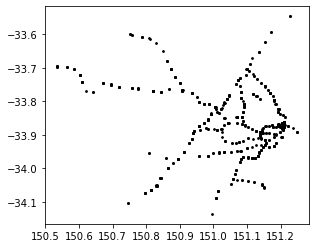

In [32]:
inc_map = inc_11_16
inc_map['btm40_11_pct'].replace(to_replace=np.nan, value=0, inplace=True)
inc_map['btm40_16_pct'].replace(to_replace=np.nan, value=0, inplace=True)
stations = gpd.read_file('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\Transportation Shapefiles\\entrances_ucl_ryan.dbf')
stations.plot(markersize=3, color="black")

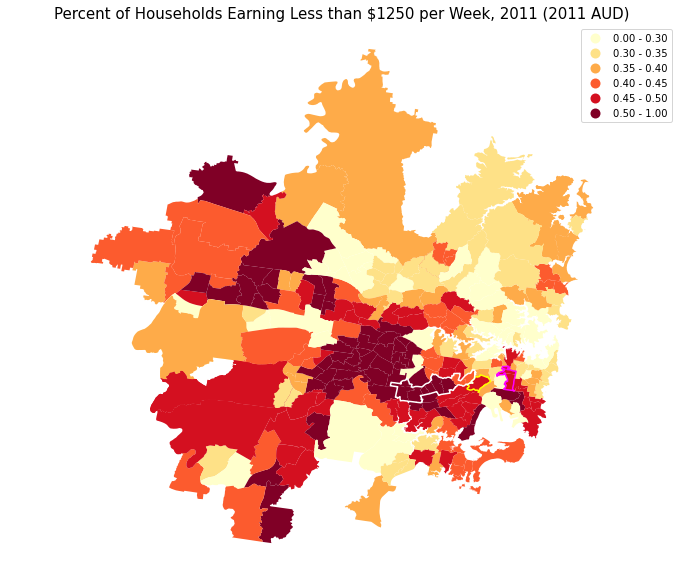

In [33]:
figure, ax = plt.subplots(figsize=(12,10))
base = inc_map.plot(column="btm40_11_pct", scheme='user_defined', 
                    classification_kwds={'bins':[0.3, 0.35, 0.4, 0.45, 0.5]}, 
                    legend=True, ax=ax, cmap="YlOrRd")

ax.set_title('Percent of Households Earning Less than $1250 per Week, 2011 (2011 AUD)', 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "white", linewidth = 1.5);

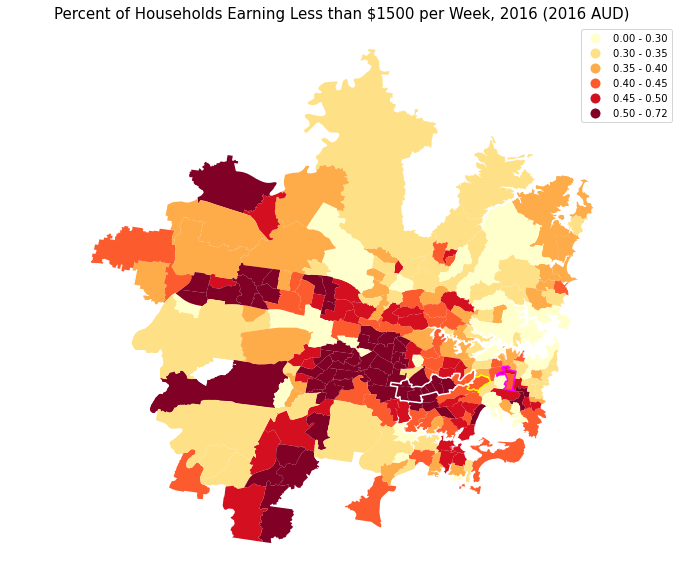

In [34]:
figure, ax = plt.subplots(figsize=(12,10))
base = inc_map.plot(column="btm40_16_pct", scheme='user_defined', 
                    classification_kwds={'bins':[0.3, 0.35, 0.4, 0.45, 0.5]}, 
                    legend=True, ax=ax, 
                    cmap="YlOrRd")

ax.set_title('Percent of Households Earning Less than $1500 per Week, 2016 (2016 AUD)', 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "white", linewidth = 1.5);

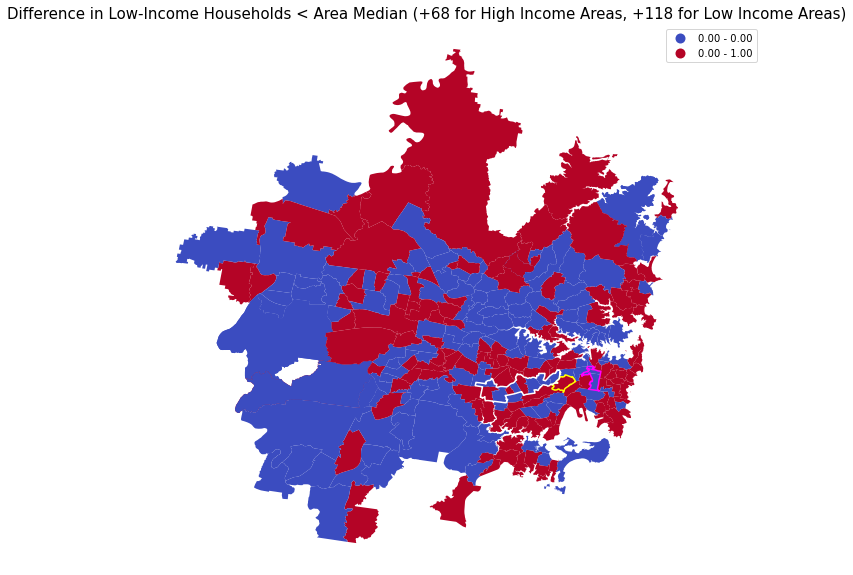

In [35]:
figure, ax = plt.subplots(figsize=(12,10))
base = inc_map.plot(column="loss_ovmed", 
                    scheme = "fisher_jenks", 
                    k = 2, legend=True, ax=ax, cmap="coolwarm")

ax.set_title('Difference in Low-Income Households < Area Median (+68 for High Income Areas, +118 for Low Income Areas)', 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "white", linewidth = 1.5);

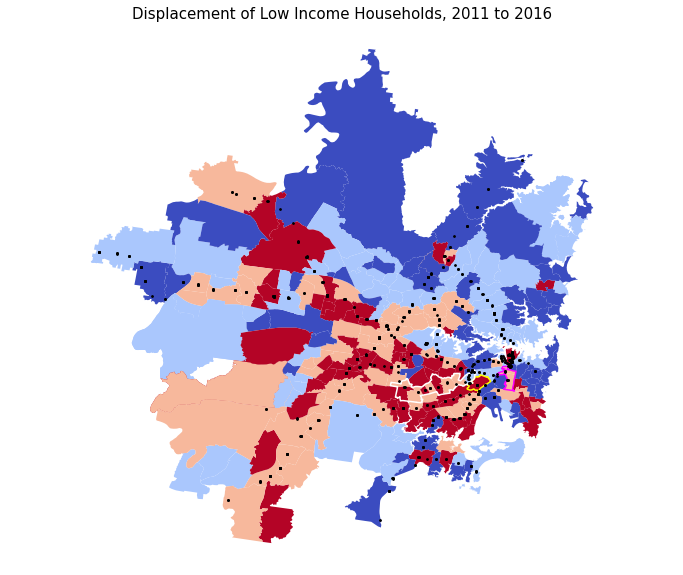

In [36]:
figure, ax = plt.subplots(figsize=(12,10))
base = inc_map.plot(column="losstypes", 
                    scheme = "fisher_jenks", 
                    k = 4, legend=False, 
                    ax=ax, 
                    cmap="coolwarm")

ax.set_title('Displacement of Low Income Households, 2011 to 2016', 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "white", linewidth = 1.5);

stations.plot(ax=base, markersize=3, color="black");

<a id="section3" ></a>
##  Occupation - Manager or Professional, 2011 and 2016

In [37]:
#read in B45B Table (2011): Occupation by Age by Sex
b45 = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2011_census_files\\SA2_NSW\\2011Census_B45B_NSW_SA2_short.csv')

#read in G57B Table (2016): Occupation by Age by Sex
g57 = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2016_census_files\\SA2_NSW\\2016Census_G57B_NSW_SA2.csv')

### Cleaning 2011 Table B45B

In [38]:
#keep only the SA2 and managers, professionals, totals columns
b45 = b45[['region_id', 'P_Tot_Managers', 'P_Tot_Professionals', 'P_Tot_Tot']]

#sum managers and professionals
b45['mgr_prf_11'] = (b45['P_Tot_Managers'] + b45['P_Tot_Professionals'])

b45.rename(columns={'region_id':'SA2_MAINCODE_2011', 'P_Tot_Tot':'total_11'}, inplace=True)

### Correspondence: Fitting 2011 Data to 2016 Geographies

In [39]:
#merge many:many, joining income B45 table (NSW) to the correspondence table (all of Australia)
occ_2011 = pd.merge(b45,corr,on='SA2_MAINCODE_2011',how='right')

#apply correspondence ratio to 2011 data to fit to 2016 SA2 areas
occ_2011['mgr_prf_11_sa2'] = occ_2011['mgr_prf_11'] * occ_2011['RATIO']
occ_2011['total_11_sa2'] = occ_2011['total_11'] * occ_2011['RATIO']

# drop null values
occ_2011.dropna(inplace=True)

### Cleaning 2016 Table G57

In [40]:
#sum managers and professionals
g57['mgr_prf_16'] = (g57['P_Tot_Managers'] + g57['P_Tot_Professionals'])

g57.rename(columns={'P_Tot_Tot':'total_16'}, inplace=True)

#keep only the SA2 and managers, professionals, totals columns
occ_2016 = g57[['SA2_MAINCODE_2016', 'mgr_prf_16', 'total_16']].copy()

In [41]:
occ_2011_sa2 = occ_2011.copy()

#merge 2011 and 2016 tables
occupation = pd.merge(occ_2011_sa2,occ_2016,on='SA2_MAINCODE_2016',how="right")

#merge 2011 and 2016 income data with UCL SA2 data
occ_11_16 = pd.merge(syd_ucl, occupation, left_on='SA2_MAIN16', right_on='SA2_MAINCODE_2016', how='left').copy()

### Calculate Percents and Percent Change, 2011 to 2016

In [42]:
#calculate % employed persons 15+ with occupation of Manager or Professional
occ_11_16['mgr_prf_11_pct'] = occ_11_16['mgr_prf_11_sa2']/occ_11_16['total_11_sa2']
occ_11_16['mgr_prf_16_pct'] = occ_11_16['mgr_prf_16']/occ_11_16['total_16']

#determine what % of employed people 15+ work as Manager or Professional in median SA2 in 2011 (answer: 36.0396%)
print(occ_11_16['mgr_prf_11_pct'].describe(percentiles=[.2,.4,.6,.8]))
print("")

#dummy variable for SA2s where % people employed as Manager or Professional < regional median (36.0396%) 2011
occ_11_16['mgr_prf_11_pct_ovregmed'] = np.where(occ_11_16['mgr_prf_11_pct'] < 0.360396, 1, 0)

#determine what % of employed people 15+ work as Manager or Professional in median SA2 in 2016 (answer: 38.3621%)
print(occ_11_16['mgr_prf_16_pct'].describe())
print("")

#dummy variable for SA2s where % people employed as Manager or Professional < regional median (38.3621%) 2016
occ_11_16['mgr_prf_16_pct_ovregmed'] = np.where(occ_11_16['mgr_prf_16_pct'] < 0.383621, 1, 0)

#calculate difference in percent
#subtract: [2016 % of people Mgr or Prf] minus [2011 % of people Mgr or Prf]
occ_11_16['pdiff_mgr_prf'] =  (occ_11_16['mgr_prf_16_pct']) - (occ_11_16['mgr_prf_11_pct'])

#calculate percent change
#divide: [percent difference] / [2011 %]
occ_11_16['pchg_pct_mgr_prf'] = (occ_11_16['pdiff_mgr_prf'])/(occ_11_16['mgr_prf_11_pct'])

#determine what % change in people employed as Manager or Professional in median SA2 (answer: 3.4379%)
print(occ_11_16['pchg_pct_mgr_prf'].describe(percentiles=[.2,.4,.6,.8]))
print("")

#dummy variable for SA2s where % change in SA2 > regional median (+3.4379%)
occ_11_16['pchg_pct_mgr_prf_ovregmed'] = np.where(occ_11_16["pchg_pct_mgr_prf"] > 0.034379, 1, 0)

count    269.000000
mean       0.373188
std        0.147386
min        0.000000
20%        0.242668
40%        0.315310
50%        0.359390
60%        0.409754
80%        0.502184
max        1.000000
Name: mgr_prf_11_pct, dtype: float64

count    268.000000
mean       0.387935
std        0.142926
min        0.000000
25%        0.269310
50%        0.383480
75%        0.492846
max        0.684514
Name: mgr_prf_16_pct, dtype: float64

count    266.000000
mean            inf
std             NaN
min       -1.000000
20%        0.006751
40%        0.025084
50%        0.034499
60%        0.040396
80%        0.073515
max             inf
Name: pchg_pct_mgr_prf, dtype: float64



<a id="section3.1" ></a>
### Mapping Occupation - Manager or Professional

In [43]:
occ_map = occ_11_16
occ_map.fillna(0,inplace=True)

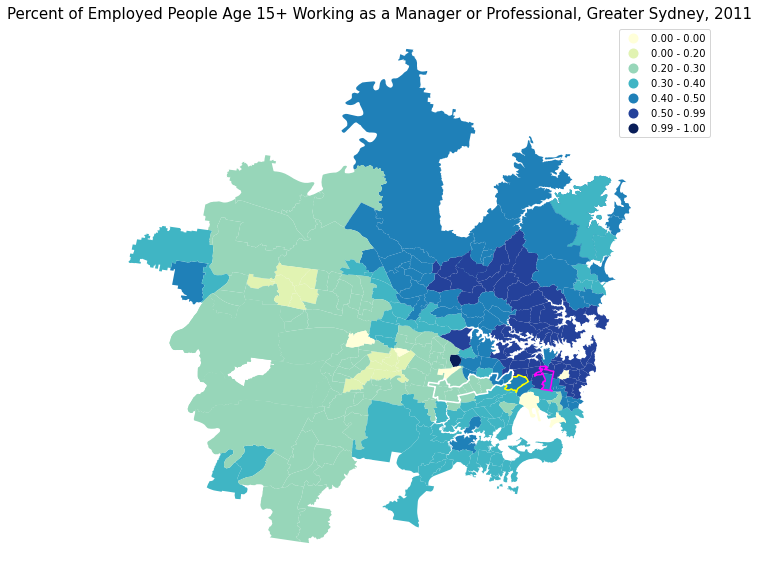

In [44]:
figure, ax = plt.subplots(figsize=(12,10))
base = occ_map.plot(column="mgr_prf_11_pct", 
                    scheme='user_defined', 
                    classification_kwds={'bins':[0,0.2, 0.3, 0.4, 0.5,0.99,1]}, 
                    legend=True, ax=ax, cmap="YlGnBu")

ax.set_title("Percent of Employed People Age 15+ Working as a Manager or Professional, Greater Sydney, 2011", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "white", linewidth = 1.5);

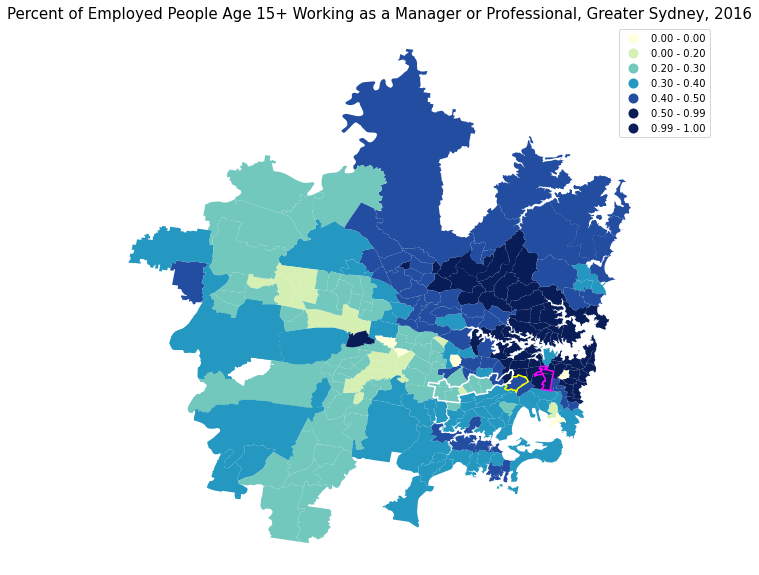

In [45]:
figure, ax = plt.subplots(figsize=(12,10))
base = occ_map.plot(column="mgr_prf_16_pct", 
                    scheme='user_defined', 
                    classification_kwds={'bins':[0,0.2, 0.3, 0.4, 0.5,0.99,1]}, 
                    legend=True, ax=ax, cmap="YlGnBu")

ax.set_title("Percent of Employed People Age 15+ Working as a Manager or Professional, Greater Sydney, 2016", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "white", linewidth = 1.5);

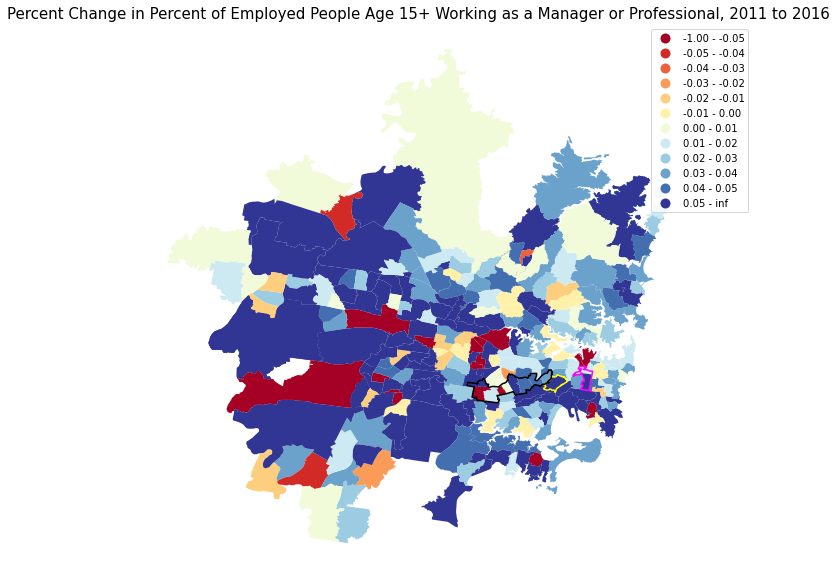

In [46]:
figure, ax = plt.subplots(figsize=(12,10))
base = occ_map.plot(column="pchg_pct_mgr_prf", 
                    scheme='user_defined', 
                    classification_kwds={'bins':[-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05]}, 
                    legend=True, ax=ax, cmap="RdYlBu")

ax.set_title("Percent Change in Percent of Employed People Age 15+ Working as a Manager or Professional, 2011 to 2016", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

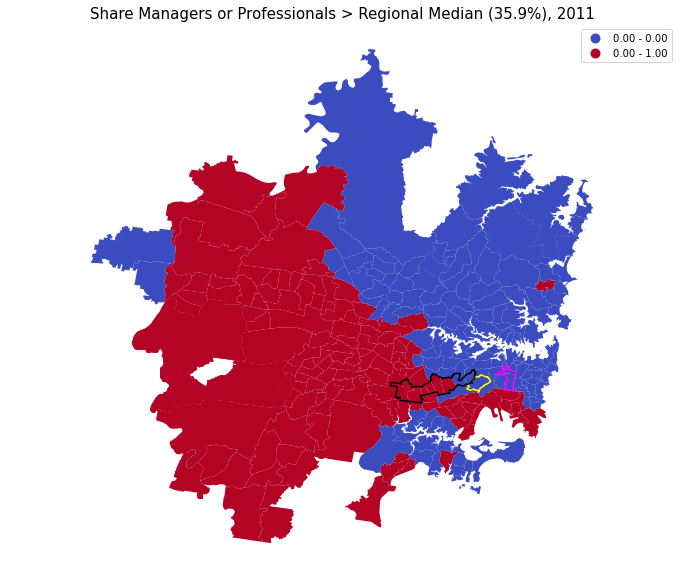

In [47]:
figure, ax = plt.subplots(figsize=(12,10))
base = occ_map.plot(column="mgr_prf_11_pct_ovregmed", 
                    scheme = "fisher_jenks", 
                    k = 2, legend=True, ax=ax, cmap="coolwarm")

ax.set_title("Share Managers or Professionals > Regional Median (35.9%), 2011", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

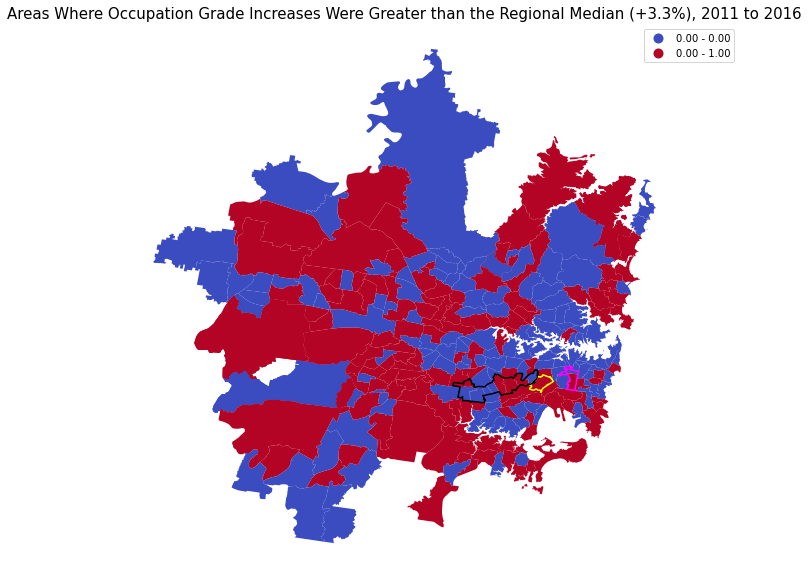

In [48]:
figure, ax = plt.subplots(figsize=(12,10))
base = occ_map.plot(column="pchg_pct_mgr_prf_ovregmed", 
                    scheme = "fisher_jenks", k = 2, 
                    legend=True, ax=ax, cmap="coolwarm")

ax.set_title("Areas Where Occupation Grade Increases Were Greater than the Regional Median (+3.3%), 2011 to 2016", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

<a id="section4" ></a>
##  Unemployment and Migration, 2011 and 2016

In [49]:
#read in B37 Table (2011): Selected Labour Force, Education and Migration Characteristics by Sex
b37 = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2011_census_files\\SA2_NSW\\2011Census_B37_NSW_SA2_short.csv')

#read in G40 Table (2016): Selected Labour Force, Education and Migration Characteristics by Sex
g40 = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2016_census_files\\SA2_NSW\\2016Census_G40_NSW_SA2.csv')

In [50]:
#keep only the SA2, % unemployment (all persons), and same vs. different addresses for 1 and 5 years ago 
# (all persons)
b37 = b37[['region_id', 'P_15_yrs_over_P', 
           'lfs_Emplyed_wrked_full_time_P', 'lfs_Emplyed_wrked_part_time_P', 
           'lfs_Employed_away_from_work_P', 'lfs_Unmplyed_lookng_for_wrk_P', 'lfs_Tot_LF_P', 
           'Migtn_Lvd_same_add_1_yr_ago_P', 'Migtn_Lvd_Diff_add_1_yr_ago_P', 
          'Migtn_Lvd_sme_add_5_yrs_ago_P', 'Mign_Lvd_Diff_add_5_yrs_ago_P']]

# Rename Columns
b37.rename(columns={'region_id':'SA2_MAINCODE_2011', 
                    'P_15_yrs_over_P':'total_11', 
                    'lfs_Emplyed_wrked_full_time_P':'lf_empl_full_11', 
                    'lfs_Emplyed_wrked_part_time_P':'lf_empl_part_11', 
                    'lfs_Employed_away_from_work_P':'lf_empl_away_11', 
                    'lfs_Unmplyed_lookng_for_wrk_P':'lf_unemp_11', 
                    'lfs_Tot_LF_P':'lf_total_11',
                    'Migtn_Lvd_same_add_1_yr_ago_P':'1yr_same_11', 
                    'Migtn_Lvd_Diff_add_1_yr_ago_P':'1yr_diff_11', 
                    'Migtn_Lvd_sme_add_5_yrs_ago_P':'5yr_same_11', 
                    'Mign_Lvd_Diff_add_5_yrs_ago_P':'5yr_diff_11'}, inplace=True)

#one value for employed
b37['lf_empl_11'] = b37['lf_empl_full_11'] + b37['lf_empl_part_11'] + b37['lf_empl_away_11']

#reduce dataframe to needed columns
b37 = b37[['SA2_MAINCODE_2011', 'total_11', 'lf_empl_11', 'lf_unemp_11', 'lf_total_11', '1yr_same_11', 
           '1yr_diff_11', '5yr_same_11', '5yr_diff_11']]

### Correspondence: Fitting 2011 Data to 2016 Geographies

In [51]:
#merge many:many, joining income B37 table (NSW) to the correspondence table (all of Australia)
emp_mig_2011 = pd.merge(b37,corr,on='SA2_MAINCODE_2011',how='right')

#apply correspondence ratio
emp_mig_2011['total_11_sa2'] = emp_mig_2011['total_11'] * emp_mig_2011['RATIO']
emp_mig_2011['lf_empl_11_sa2'] = emp_mig_2011['lf_empl_11'] * emp_mig_2011['RATIO']
emp_mig_2011['lf_unemp_11_sa2'] = emp_mig_2011['lf_unemp_11'] * emp_mig_2011['RATIO']
emp_mig_2011['lf_total_11_sa2'] = emp_mig_2011['lf_total_11'] * emp_mig_2011['RATIO']
emp_mig_2011['1yr_same_11_sa2'] = emp_mig_2011['1yr_same_11'] * emp_mig_2011['RATIO']
emp_mig_2011['1yr_diff_11_sa2'] = emp_mig_2011['1yr_diff_11'] * emp_mig_2011['RATIO']
emp_mig_2011['5yr_same_11_sa2'] = emp_mig_2011['5yr_same_11'] * emp_mig_2011['RATIO']
emp_mig_2011['5yr_diff_11_sa2'] = emp_mig_2011['5yr_diff_11'] * emp_mig_2011['RATIO']

# remove n/a 
emp_mig_2011.dropna(inplace=True)
emp_mig_2011_sa2 = emp_mig_2011

### Cleaning Table G40 (2016)

In [52]:
#keep only the SA2, % unemployment (all persons), and same vs. different addresses for 1 and 5 years ago 
# (all persons)
g40 = g40[['SA2_MAINCODE_2016', 'P_15_yrs_over_P', 
           'lfs_Emplyed_wrked_full_time_P', 'lfs_Emplyed_wrked_part_time_P', 
           'lfs_Employed_away_from_work_P', 'lfs_Unmplyed_lookng_for_wrk_P', 'lfs_Tot_LF_P', 
           'Migtn_Lvd_same_add_1_yr_ago_P', 'Migtn_Lvd_Diff_add_1_yr_ago_P', 
          'Migtn_Lvd_sme_add_5_yrs_ago_P', 'Mign_Lvd_Diff_add_5_yrs_ago_P']]

g40.rename(columns={'P_15_yrs_over_P':'total_16', 
                    'lfs_Emplyed_wrked_full_time_P':'lf_empl_full_16', 
                    'lfs_Emplyed_wrked_part_time_P':'lf_empl_part_16', 
                    'lfs_Employed_away_from_work_P':'lf_empl_away_16', 
                    'lfs_Unmplyed_lookng_for_wrk_P':'lf_unemp_16', 
                    'lfs_Tot_LF_P':'lf_total_16',
                    'Migtn_Lvd_same_add_1_yr_ago_P':'1yr_same_16', 
                    'Migtn_Lvd_Diff_add_1_yr_ago_P':'1yr_diff_16', 
                    'Migtn_Lvd_sme_add_5_yrs_ago_P':'5yr_same_16', 
                    'Mign_Lvd_Diff_add_5_yrs_ago_P':'5yr_diff_16'}, inplace=True)

#one value for employed
g40['lf_empl_16'] = g40['lf_empl_full_16'] + g40['lf_empl_part_16'] + g40['lf_empl_away_16']

#reduce dataframe to needed columns
emp_mig_2016 = g40[['SA2_MAINCODE_2016', 'total_16', 'lf_empl_16', 'lf_unemp_16', 'lf_total_16', '1yr_same_16', 
                    '1yr_diff_16', '5yr_same_16', '5yr_diff_16']].copy()

### Merge 2011 and 2016 Tables

In [53]:
#merge 2011 and 2016 tables
emp_mig = pd.merge(emp_mig_2011_sa2,emp_mig_2016,on='SA2_MAINCODE_2016',how="right")
emp_mig.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 591 entries, 0 to 590
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SA2_MAINCODE_2011  590 non-null    float64
 1   total_11           590 non-null    float64
 2   lf_empl_11         590 non-null    float64
 3   lf_unemp_11        590 non-null    float64
 4   lf_total_11        590 non-null    float64
 5   1yr_same_11        590 non-null    float64
 6   1yr_diff_11        590 non-null    float64
 7   5yr_same_11        590 non-null    float64
 8   5yr_diff_11        590 non-null    float64
 9   SA2_NAME_2011      590 non-null    object 
 10  SA2_MAINCODE_2016  591 non-null    int64  
 11  SA2_NAME_2016      590 non-null    object 
 12  RATIO              590 non-null    float64
 13  PERCENTAGE         590 non-null    float64
 14  total_11_sa2       590 non-null    float64
 15  lf_empl_11_sa2     590 non-null    float64
 16  lf_unemp_11_sa2    590 non

In [54]:
#merge 2011 and 2016 income data with UCL SA2 data
labor = pd.merge(syd_ucl, emp_mig, left_on='SA2_MAIN16', right_on='SA2_MAINCODE_2016', how='left').copy()

In [55]:
dup_sa2=labor.SA2_MAIN16.duplicated()
labor[dup_sa2]

,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry,SA2_MAINCODE_2011,total_11,lf_empl_11,lf_unemp_11,lf_total_11,1yr_same_11,1yr_diff_11,5yr_same_11,5yr_diff_11,SA2_NAME_2011,SA2_MAINCODE_2016,SA2_NAME_2016,RATIO,PERCENTAGE,total_11_sa2,lf_empl_11_sa2,lf_unemp_11_sa2,lf_total_11_sa2,1yr_same_11_sa2,1yr_diff_11_sa2,5yr_same_11_sa2,5yr_diff_11_sa2,total_16,lf_empl_16,lf_unemp_16,lf_total_16,1yr_same_16,1yr_diff_16,5yr_same_16,5yr_diff_16
126,121021406,11406,Normanhurst - Thornleigh - Westleigh,12102,Hornsby,121,Sydney - North Sydney and Hornsby,1GSYD,Greater Sydney,1,New South Wales,9.9882,"POLYGON ((151.10161 -33.71981, 151.10177 -33.7...",121021406.0,14133.0,8753.0,376.0,9129.0,15479.0,1876.0,10963.0,5258.0,Normanhurst - Thornleigh - Westleigh,121021406,Normanhurst - Thornleigh - Westleigh,1.000000,100.000000,14133.000000,8753.000000,376.000000,9129.000000,15479.000000,1876.000000,10963.000000,5258.000000,14678,9024,399,9422,15627,1806,11191,5551
145,122021421,11421,Bayview - Elanora Heights,12202,Pittwater,122,Sydney - Northern Beaches,1GSYD,Greater Sydney,1,New South Wales,64.5830,"MULTIPOLYGON (((151.28681 -33.63778, 151.28684...",122021423.0,17363.0,11199.0,354.0,11553.0,17686.0,3071.0,11341.0,7926.0,Warriewood - Mona Vale,122021421,Bayview - Elanora Heights,0.001465,0.146476,25.433322,16.404295,0.518539,16.922834,25.906453,4.498401,16.612297,11.610005,8797,5020,165,5185,8732,1066,6154,3370
177,124031463,11463,Mulgoa - Luddenham - Orchard Hills,12403,Penrith,124,Sydney - Outer West and Blue Mountains,1GSYD,Greater Sydney,1,New South Wales,158.6776,"POLYGON ((150.65436 -33.76876, 150.65493 -33.7...",124031463.0,5210.0,3339.0,134.0,3473.0,5571.0,655.0,4251.0,1667.0,Mulgoa - Luddenham - Orchard Hills,124031463,Mulgoa - Luddenham - Orchard Hills,0.979780,97.978037,5104.655884,3271.486756,131.290574,3402.777329,5458.356608,641.756162,4165.046480,1633.293927,7460,4971,196,5169,7411,1269,4208,4079
226,127011505,11505,Austral - Greendale,12701,Bringelly - Green Valley,127,Sydney - South West,1GSYD,Greater Sydney,1,New South Wales,110.7146,"POLYGON ((150.72366 -33.90239, 150.72374 -33.9...",127011506.0,5132.0,2838.0,132.0,2970.0,5168.0,665.0,4031.0,1486.0,Cobbitty - Leppington,127011505,Austral - Greendale,0.002291,0.229090,11.756899,6.501574,0.302399,6.803973,11.839371,1.523449,9.234618,3.404277,7261,3854,212,4063,7309,649,5711,1942
233,127011597,11597,West Hoxton - Middleton Grange,12701,Bringelly - Green Valley,127,Sydney - South West,1GSYD,Greater Sydney,1,New South Wales,9.2626,"POLYGON ((150.82730 -33.92347, 150.82829 -33.9...",127011508.0,13634.0,8901.0,516.0,9417.0,15562.0,2192.0,10548.0,5886.0,Hoxton Park - Horningsea Park,127011597,West Hoxton - Middleton Grange,0.517517,51.751683,7055.824051,4606.417037,267.038669,4873.455706,8053.596442,1134.396826,5458.767206,3046.103885,11152,7202,435,7640,12281,1740,6998,6142


### UNEMPLOYMENT

#### Calculate Percents and Percent Change, 2011 to 2016

In [56]:
#calculate unemployment rates
labor['unemp_11_pct'] = ((labor['lf_unemp_11_sa2'])/(labor['lf_total_11_sa2']))
labor['unemp_16_pct'] = ((labor['lf_unemp_16'])/(labor['lf_total_16']))

#calculate employment-population ratios
labor['emp_pop_11_pct'] = ((labor['lf_empl_11_sa2'])/(labor['total_11_sa2']))
labor['emp_pop_16_pct'] = ((labor['lf_empl_16'])/(labor['total_16']))

#determine unemployment rate in median SA2: 5.1820% (2011)
print("Describe distribution of unemployed persons.")
print(labor['unemp_11_pct'].describe(percentiles=[.2,.4,.6,.8]))

#dummy variable for SA2s where unemployment rate > regional median (5.1820%) 2011
labor['unemp_11_ovregmed'] = np.where(labor['unemp_11_pct'] > 0.051820, 1, 0)

#determine unemployment rate in median SA2: 5.2437% (2016)
labor['unemp_16_pct'].describe(percentiles=[.2,.4,.6,.8])

#dummy variable for SA2s where unemployment rate > regional median (5.2437%) 2016
labor['unemp_16_ovregmed'] = np.where(labor['unemp_16_pct'] > 0.052437, 1, 0)

#calculate difference in unemployment rate: 2016-2011
labor['pdiff_unemp'] = ((labor['unemp_16_pct'])-(labor['unemp_11_pct']))

#calculate percent change
#divide: [percent difference] / [2011 %]
labor['pchg_unemp'] = (labor['pdiff_unemp'])/(labor['unemp_11_pct'])

#determine % change in unemployment rate in median SA2: +5.3995%
labor['pchg_unemp'].describe(percentiles=[.2,.4,.6,.8])

#dummy variable for SA2s where reduction in unemployment rate > regional median (+5.3995%) 2011
labor['pchg_unemp_ovregmed'] = np.where(labor['pchg_unemp'] < 0.053995, 1, 0)

Describe distribution of unemployed persons.
count    269.000000
mean       0.057712
std        0.031886
min        0.000000
20%        0.036652
40%        0.045060
50%        0.050957
60%        0.058032
80%        0.075813
max        0.375000
Name: unemp_11_pct, dtype: float64


### Migration 
#### Calculate Percents and Percent Change, 2011 to 2016

**NOTE: We decided that we were not including 5 year turnover as it is almost the same as the 1 year turnover for 2016, but includes some northern coastal suburbs without capturing accelerating turnover in Inner West.** 

In [57]:
#calculate % 1 yr difference and 5 yr difference, 2011
labor['1yr_diff_11_pct'] = ((labor['1yr_diff_11_sa2'])/((labor['1yr_diff_11_sa2'])+(labor['1yr_same_11_sa2'])))
labor['5yr_diff_11_pct'] = ((labor['5yr_diff_11_sa2'])/((labor['5yr_diff_11_sa2'])+(labor['5yr_same_11_sa2'])))

#calculate % 1 yr difference and 5 yr difference, 2016
labor['1yr_diff_16_pct'] = ((labor['1yr_diff_16'])/((labor['1yr_diff_16'])+(labor['1yr_same_16'])))
labor['5yr_diff_16_pct'] = ((labor['5yr_diff_16'])/((labor['5yr_diff_16'])+(labor['5yr_same_16'])))

#determine % 1 yr turnover in median SA2: 14.0525% (2016)
print("Describe distribution of 1 year turnover in median SA2:")
print(labor['1yr_diff_16_pct'].describe(percentiles=[.2,.4,.6,.8]))

#dummy variable for SA2s where unemployment rate > regional median (14.0525%) 2016
labor['1yr_diff_ovregmed'] = np.where(labor['1yr_diff_16_pct'] > 0.140525, 1, 0)

Describe distribution of 1 year turnover in median SA2:
count    269.000000
mean       0.158579
std        0.069050
min        0.000000
20%        0.108108
40%        0.130633
50%        0.139732
60%        0.152909
80%        0.205370
max        0.666667
Name: 1yr_diff_16_pct, dtype: float64


In [58]:
# Rebuild variable names to better capture in mapping

labor['move1yr_pct_16'] = labor['1yr_diff_16_pct']
labor['move1yr_ovregmed_16'] = labor['1yr_diff_ovregmed']
labor['unemploy_11'] = labor['unemp_11_pct']
labor['unemploy_16'] = labor['unemp_16_pct']
labor['unemploy_ovregmed_11'] = labor['unemp_11_ovregmed']
labor['unemploy_ovregmed_16'] = labor['unemp_16_ovregmed']

<a id="section4.1" ></a>
## Mapping Unemployment and Migration

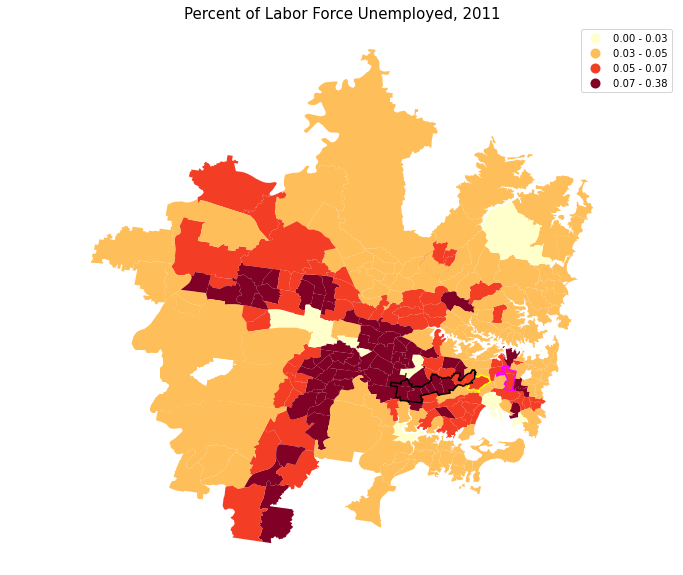

In [59]:
figure, ax = plt.subplots(figsize=(12,10))
base = labor.plot(column="unemp_11_pct", 
                  scheme='user_defined', 
                  classification_kwds={'bins':[0.03,0.05,0.07]}, 
                  legend=True, ax=ax, cmap="YlOrRd")

ax.set_title("Percent of Labor Force Unemployed, 2011", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

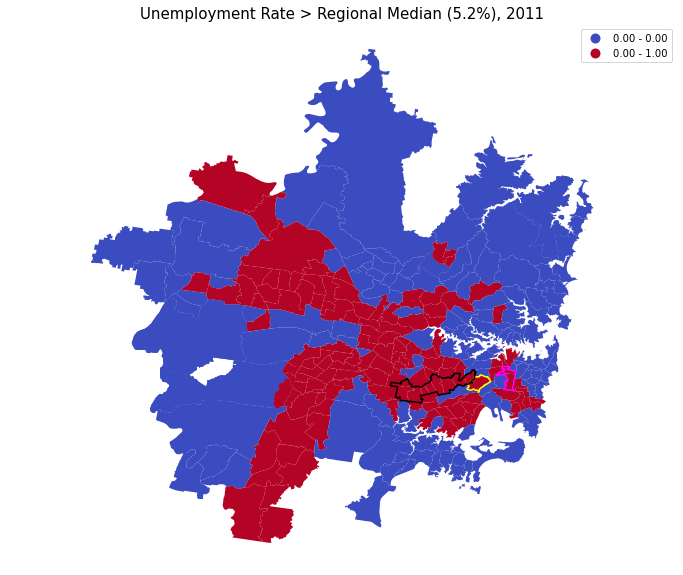

In [60]:
figure, ax = plt.subplots(figsize=(12,10))
base = labor.plot(column="unemp_11_ovregmed", scheme = "fisher_jenks", k = 2, legend=True, ax=ax, cmap="coolwarm")
ax.set_title("Unemployment Rate > Regional Median (5.2%), 2011", fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

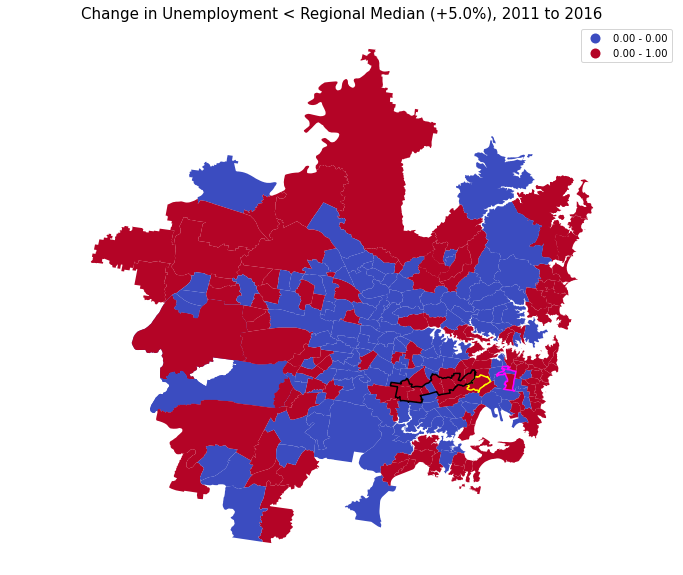

In [61]:
figure, ax = plt.subplots(figsize=(12,10))
base = labor.plot(column="pchg_unemp_ovregmed", scheme = "fisher_jenks", k = 2, legend=True, ax=ax, cmap="coolwarm")
ax.set_title("Change in Unemployment < Regional Median (+5.0%), 2011 to 2016", fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

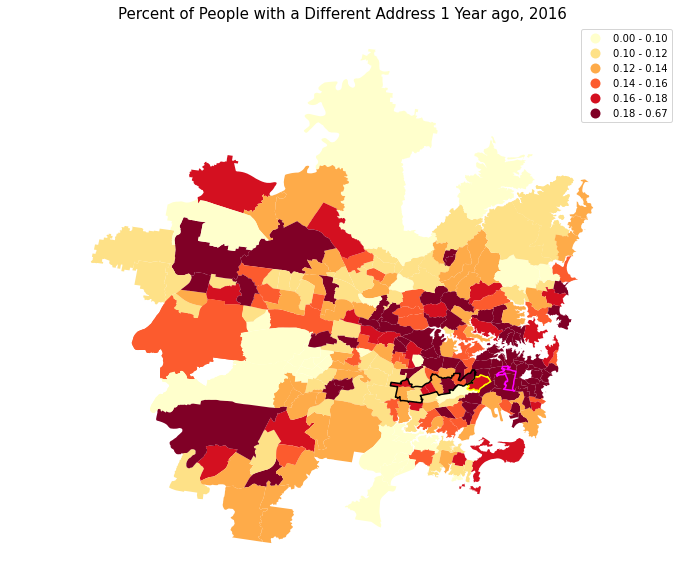

In [62]:
figure, ax = plt.subplots(figsize=(12,10))
base = labor.plot(column="1yr_diff_16_pct", scheme='user_defined', classification_kwds={'bins':[0.1,0.12,0.14,0.16,0.18]}, legend=True, ax=ax, cmap="YlOrRd")
ax.set_title("Percent of People with a Different Address 1 Year ago, 2016", fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

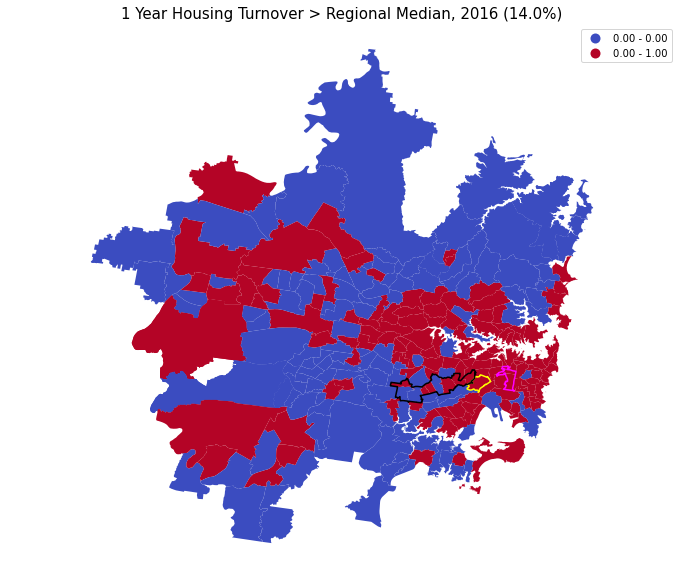

In [63]:
figure, ax = plt.subplots(figsize=(12,10))
base = labor.plot(column="1yr_diff_ovregmed", scheme = "fisher_jenks", k = 2, legend=True, ax=ax, cmap="coolwarm")
ax.set_title("1 Year Housing Turnover > Regional Median, 2016 (14.0%)", fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

<a id="section5" ></a>
## Indigenous Population 

In [64]:
#read in B01 Table (2011): Selected Labour Force, Education and Migration Characteristics by Sex
b01 = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2011_census_files\\SA2_NSW\\2011Census_B01_NSW_SA2_short.csv')

#read in G01 Table (2016): Selected Labour Force, Education and Migration Characteristics by Sex
g01 = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2016_census_files\\SA2_NSW\\2016Census_G01_NSW_SA2.csv')

In [65]:
# isolate desired variables
b01 = b01[['region_id', 'Tot_P_P', 'Indigenous_P_Tot_P']]

# rename variables 
b01.rename(columns={'region_id':'SA2_MAINCODE_2011',
                    'Tot_P_P':'total_pop',
                    'Indigenous_P_Tot_P':'indig_pop'}, inplace=True)



### Correspondence of 2011 data to 2016 SA2s

In [66]:
# merge indigenous population to 2011 correspondence
indig_2011 = pd.merge(b01,corr,on='SA2_MAINCODE_2011',how='right')

#apply correspondence ratio
indig_2011['total_11_sa2'] = indig_2011['total_pop'] * indig_2011['RATIO']
indig_2011['indig_11_sa2'] = indig_2011['indig_pop'] * indig_2011['RATIO']

# drop null values
indig_2011.dropna(inplace=True)

indig_2011_sa2 = indig_2011

### Cleaning Table G01 (2016)

In [67]:
indig_2016 = g01[['SA2_MAINCODE_2016', 'Indigenous_P_Tot_P', 'Tot_P_P']].copy()

indig_2016.rename(columns={'Tot_P_P':'total_16',
                           'Indigenous_P_Tot_P':'indig_16'}, inplace=True)

In [68]:
# merge 2011 and 2016 data together
indig = pd.merge(indig_2011_sa2,indig_2016,on='SA2_MAINCODE_2016',how="right").copy()

#merge 2011 and 2016 data with UCL SA2 data
indigenous = pd.merge(syd_ucl, indig, left_on='SA2_MAIN16', right_on='SA2_MAINCODE_2016', how='left').copy()

### Getting Descriptive Statistics to generate typology

In [69]:
print("Describe distribution of Indigenous population in 2011")
print(indigenous['indig_11_sa2'].describe(percentiles=[.2,.4,.6,.8]))
print("")

print("Describe distribution of Indigenous population in 2016")
print(indigenous['indig_16'].describe(percentiles=[.2,.4,.6,.8]))

# create variables of percentage of indigenous folks in 2011 and 2016
indigenous['indig_pct_11'] = ((indigenous['indig_11_sa2']) / (indigenous['total_11_sa2']))
indigenous['indig_pct_16'] = ((indigenous['indig_16']) / (indigenous['total_16']))

print("Describe indigenous population as percentage of the entire population.")
print(indigenous['indig_pct_11'].describe(percentiles=[.2,.4,.6,.8]))
print("")

print("Describe indigenous population as percentage of the entire population.")
print(indigenous['indig_pct_16'].describe(percentiles=[.2,.4,.6,.8]))
print("")

indigenous['indig_ovregmed_11'] = np.where((indigenous['indig_11_sa2'] > 93),1,0)
indigenous['indig_ovregmed_16'] = np.where((indigenous['indig_16'] > 115),1,0)

Describe distribution of Indigenous population in 2011
count     270.000000
mean      161.379488
std       207.786963
min         0.000000
20%        37.600000
40%        70.642364
50%        91.000000
60%       114.332619
80%       235.000000
max      1631.000000
Name: indig_11_sa2, dtype: float64

Describe distribution of Indigenous population in 2016
count     270.000000
mean      203.803704
std       254.515624
min         0.000000
20%        50.800000
40%        92.000000
50%       115.500000
60%       144.600000
80%       267.600000
max      1761.000000
Name: indig_16, dtype: float64
Describe indigenous population as percentage of the entire population.
count    268.000000
mean       0.010487
std        0.011836
min        0.000000
20%        0.003185
40%        0.004888
50%        0.006508
60%        0.008523
80%        0.015597
max        0.087702
Name: indig_pct_11, dtype: float64

Describe indigenous population as percentage of the entire population.
count    269.000000
mean 

<a id="section5.1" ></a>
### Mapping Indigenous Population 

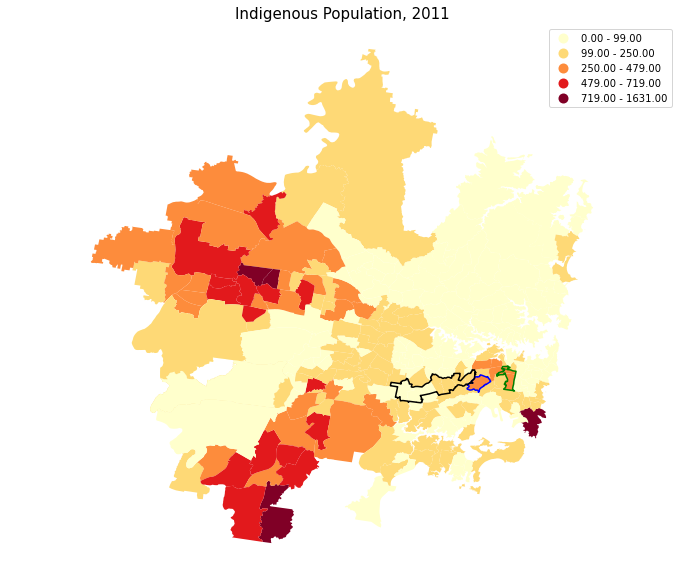

In [70]:
figure, ax = plt.subplots(figsize=(12,10))
base = indigenous.plot(column='indig_11_sa2', 
                       scheme='fisher_jenks', 
                       k=5, 
                       legend=True, ax=ax, 
                       cmap="YlOrRd")

ax.set_title('Indigenous Population, 2011', 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "green", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "blue", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

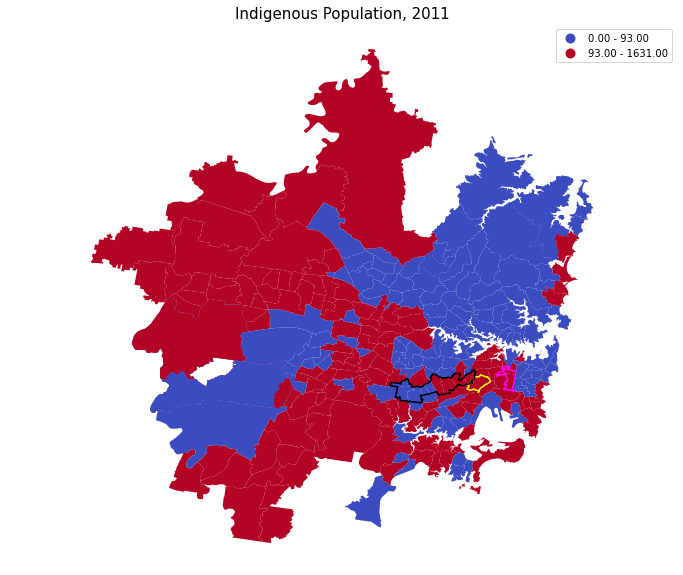

In [71]:
figure, ax = plt.subplots(figsize=(12,10))
base = indigenous.plot(column='indig_11_sa2', 
                       scheme='user_defined', 
                       classification_kwds={'bins':[93]}, 
                       legend=True, ax=ax, 
                       cmap="coolwarm")

ax.set_title('Indigenous Population, 2011', 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

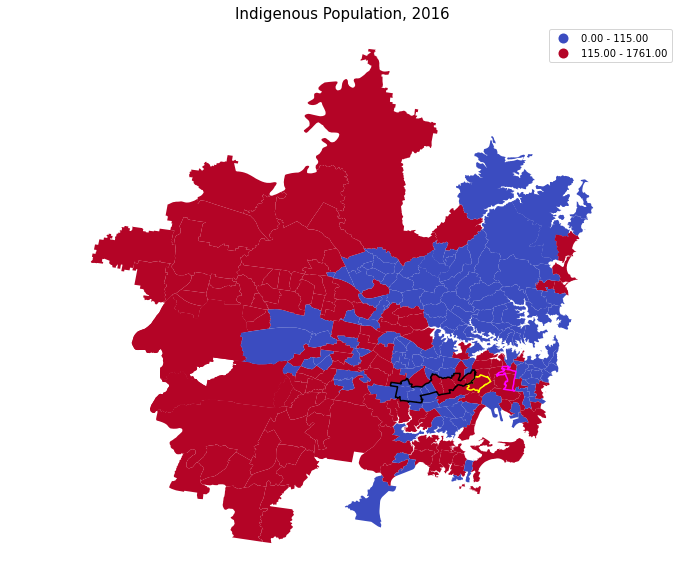

In [72]:
figure, ax = plt.subplots(figsize=(12,10))
base = indigenous.plot(column='indig_16', 
                       scheme='user_defined', 
                       classification_kwds={'bins':[115]}, 
                       legend=True, ax=ax, 
                       cmap="coolwarm")

ax.set_title('Indigenous Population, 2016', 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

<a id="section6" ></a>
## Rentals and Public Housing Analysis

In [73]:
#read in B32 Table (2011): Tenure Type and Landlord Type by Dwelling Structure
b32 = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2011_census_files\\SA2_NSW\\2011Census_B32_NSW_SA2_short.csv')

#read in G33 Table (2016): enure Type and Landlord Type by Dwelling Structure
g33 = pd.read_csv('C:\\Users\\Emman\\Box\\Spring 2020\\Displacement Studio\\Shared 228 Sydney Folder\\AU Work\\2016_census_files\\SA2_NSW\\2016Census_G33_NSW_SA2.csv')

### Data cleaning

In [74]:
#restrict data frame to needed variables
b32 = b32[['region_id', 'R_ST_h_auth_Total', 'R_Tot_Total', 'Ten_type_NS_Total', 'Total_Total']]

#rename variables
b32.rename(columns={'region_id':'SA2_MAINCODE_2011',
                    'R_ST_h_auth_Total':'ten_rent_public_11', 
                    'R_Tot_Total':'ten_rent_all_11',
                    'Ten_type_NS_Total':'ten_typeNS_11',
                    'Total_Total':'ten_total_11'}, inplace=True)

#calculate a value for dwellings with tenure stated
b32['ten_typeS_11'] = b32['ten_total_11'] - b32['ten_typeNS_11']

#merge many:many, joining B32 table (NSW) to the correspondence table (all of Australia)
tenure_2011 = pd.merge(b32,corr,on='SA2_MAINCODE_2011',how='right')

#apply correspondence ratio
tenure_2011['ten_rent_public_11_sa2'] = tenure_2011['ten_rent_public_11'] * tenure_2011['RATIO']
tenure_2011['ten_rent_all_11_sa2'] = tenure_2011['ten_rent_all_11'] * tenure_2011['RATIO']
tenure_2011['ten_typeNS_11_sa2'] = tenure_2011['ten_typeNS_11'] * tenure_2011['RATIO']
tenure_2011['ten_typeS_11_sa2'] = tenure_2011['ten_typeS_11'] * tenure_2011['RATIO']
tenure_2011['ten_total_11_sa2'] = tenure_2011['ten_total_11'] * tenure_2011['RATIO']

tenure_2011_sa2 = tenure_2011.copy()

In [75]:
#restrict data frame to needed variables
g33 = g33[['SA2_MAINCODE_2016', 'R_ST_h_auth_Total', 'R_Tot_Total', 'Ten_type_NS_Total', 'Total_Total']]

#rename variables
g33.rename(columns={'R_ST_h_auth_Total':'ten_rent_public_16', 
                    'R_Tot_Total':'ten_rent_all_16',
                    'Ten_type_NS_Total':'ten_typeNS_16',
                    'Total_Total':'ten_total_16'}, inplace=True)

#calculate a value for dwellings with tenure stated
g33['ten_typeS_16'] = g33['ten_total_16'] - g33['ten_typeNS_16']

### Merge 2011 and 2016 Tables together

In [76]:
#merge 2011 and 2016 tables
tenure = pd.merge(tenure_2011_sa2,g33,on='SA2_MAINCODE_2016',how="right")

In [77]:
#merge 2011 and 2016 data with UCL SA2 data
tenure = pd.merge(syd_ucl, tenure, left_on='SA2_MAIN16', right_on='SA2_MAINCODE_2016', how='left').copy()
tenure.dropna(inplace=True)

### More Data Cleaning

In [78]:
tenure['ten_rent_all_11_sa2'].describe(percentiles=[.038,.05,.1,.2,.4,.6,.8])

count     270.000000
mean     1637.793997
std      1186.208793
min         0.000000
3.8%        3.000000
5%         28.646868
10%       277.100000
20%       657.037949
40%      1159.759794
50%      1464.535949
60%      1702.000000
80%      2476.000000
max      5750.000000
Name: ten_rent_all_11_sa2, dtype: float64

In [112]:
#calculate a variable for SA2s with minimum 100 occupied rental dwellings in 2011
tenure['ten_rent_min100_11'] = np.where(tenure['ten_rent_all_11_sa2'] < 100, 0, 1)

In [115]:
#calculate % of occupied dwellings that are rentals
tenure['ten_rent_pct_11'] = (tenure['ten_rent_all_11_sa2'])/(tenure['ten_typeS_11_sa2'])
tenure['ten_rent_pct_16'] = (tenure['ten_rent_all_16'])/(tenure['ten_typeS_16'])

#calculate % of occupied rental dwellings that are public housing
tenure['rent_public_pct_11'] = (tenure['ten_rent_public_11_sa2'])/(tenure['ten_rent_all_11_sa2'])
tenure['rent_public_pct_16'] = (tenure['ten_rent_public_16'])/(tenure['ten_rent_all_16'])

# calc % of all dwellings that are public rentals
tenure['ten_public_pct_11'] = (tenure['ten_rent_public_11_sa2'])/(tenure['ten_typeS_11_sa2'])
tenure['ten_public_pct_16'] = (tenure['ten_rent_public_16'])/(tenure['ten_typeS_16'])

tenure['rentals_ovregmed_16'] = np.where(tenure['ten_rent_pct_16'] > 0.334239, 1, 0)
tenure['rentals_ovregmed_11'] = np.where(tenure['ten_rent_pct_11'] > 0.309999, 1, 0)

<a id="section6.1" ></a>
## Mapping Rental and Public Housing

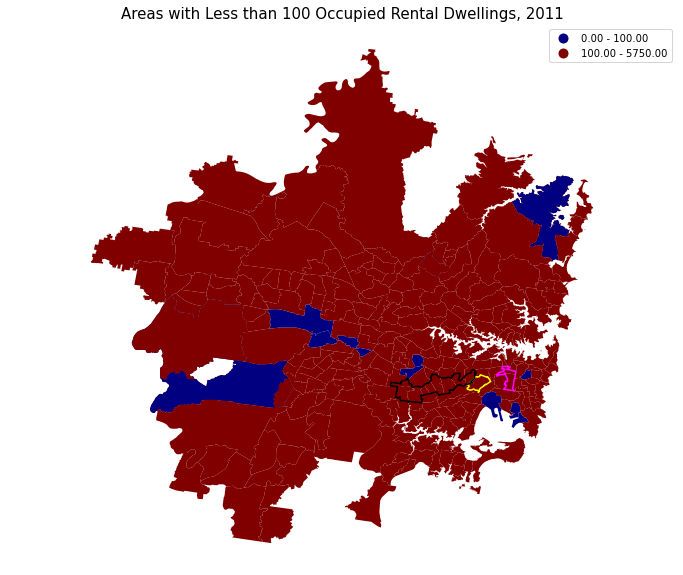

In [80]:
figure, ax = plt.subplots(figsize=(12,10))
base = tenure.plot(column='ten_rent_all_11_sa2', 
                   scheme='user_defined', 
                   classification_kwds={'bins':[100]}, 
                   legend=True, ax=ax, 
                   cmap="jet")

ax.set_title("Areas with Less than 100 Occupied Rental Dwellings, 2011", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "yellow", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

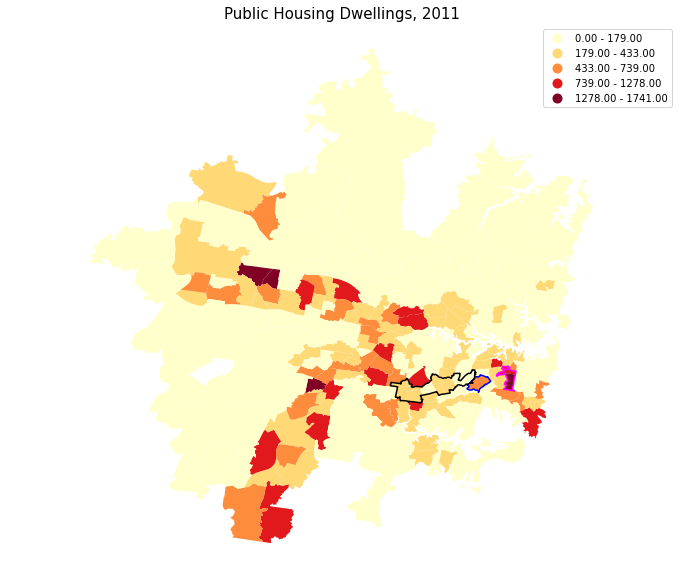

In [83]:
figure, ax = plt.subplots(figsize=(12,10))
base = tenure.plot(column='ten_rent_public_11_sa2', 
                   scheme='fisher_jenks', 
                   k=5, legend=True, ax=ax, 
                   cmap="YlOrRd")

ax.set_title("Public Housing Dwellings, 2011", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "blue", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

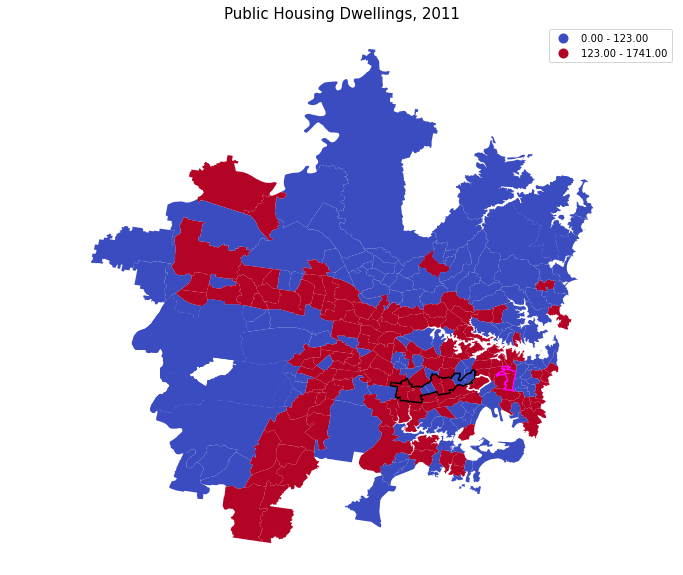

In [103]:
figure, ax = plt.subplots(figsize=(12,10))
base = tenure.plot(column='ten_rent_public_11_sa2', 
                   scheme='user_defined', 
                   classification_kwds={'bins':[123]}, 
                   legend=True, ax=ax, cmap="coolwarm")

ax.set_title("Public Housing Dwellings, 2011", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "white", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

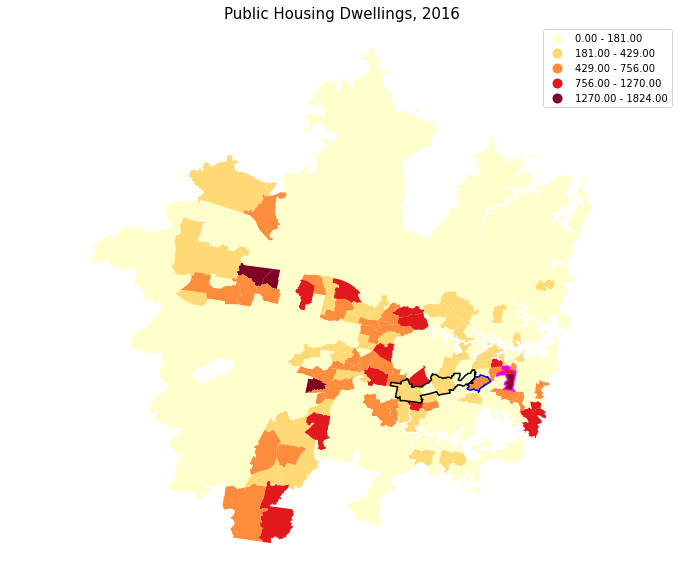

In [104]:
figure, ax = plt.subplots(figsize=(12,10))
base = tenure.plot(column='ten_rent_public_16', 
                   scheme='fisher_jenks', 
                   k=5, legend=True, ax=ax, 
                   cmap="YlOrRd")

ax.set_title("Public Housing Dwellings, 2016", 
             fontdict={'fontsize':15})

lims=plt.axis("equal")
ax.set_axis_off()

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "magenta", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "blue", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "black", linewidth = 1.5);

<a id="section7" ></a>
# Typology Map Creation


In [113]:
occ_11_16['o_mgrprf_pct_11'] = occ_11_16['mgr_prf_11_pct']
occ_11_16['o_mgrprf_pct_16'] = occ_11_16['mgr_prf_16_pct']
occ_11_16['o_mgrprf_pchg_11_16'] = occ_11_16['pchg_pct_mgr_prf']
occ_11_16['o_mgrprf_pcgh_ovregmed_11_16'] = occ_11_16['pchg_pct_mgr_prf_ovregmed']

edu_11_16['college_pct_11'] = edu_11_16['bachplus_11_pct']
edu_11_16['college_pct_16'] = edu_11_16['bachplus_16_pct']
edu_11_16['college_pchg_11_16'] = edu_11_16['pchg_pct_bachplus']
edu_11_16['college_pchg_ovregmed_11_16'] = edu_11_16['pchg_pct_bachplus_ovregmed']

tenure['rentals_ov100_11'] = tenure['ten_rent_min100_11']
tenure['rentals_pct_11'] = tenure['ten_rent_pct_11']
tenure['rentals_pct_16'] = tenure['ten_rent_pct_16']

indigenous['indig_11'] = indigenous['indig_11_sa2']


inc_11_16['lowinc_pct_11'] = inc_11_16['btm40_11_pct']
inc_11_16['lowinc_pct_16'] = inc_11_16['btm40_16_pct']
inc_11_16['diff_lowinc_11_16'] = inc_11_16['netdiff_lowinc']
inc_11_16['lowinc_ovregmed_11'] = inc_11_16['btm40_11_pct_ovregmed']
inc_11_16['loss_lowinc_ovmed_11_16'] = inc_11_16['loss_ovmed']

labor['move1yr_pct_16'] = labor['1yr_diff_16_pct']
labor['move1yr_ovregmed_16'] = labor['1yr_diff_ovregmed']
labor['unemploy_11'] = labor['unemp_11_pct']
labor['unemploy_16'] = labor['unemp_16_pct']
labor['unemploy_ovregmed_11'] = labor['unemp_11_ovregmed']
labor['unemploy_ovregmed_16'] = labor['unemp_16_ovregmed']

In [119]:
rentals = tenure[['SA2_MAINCODE_2016','rentals_ov100_11','rentals_pct_11','rentals_pct_16','rentals_ovregmed_11',
        'rentals_ovregmed_16']]

bachelors = edu_11_16[['SA2_MAINCODE_2016','college_pct_11','college_pct_16','college_pchg_11_16',
           'college_pchg_ovregmed_11_16']]

occupation = occ_11_16[['SA2_MAINCODE_2016','o_mgrprf_pct_11','o_mgrprf_pct_16','o_mgrprf_pchg_11_16',
                        'o_mgrprf_pcgh_ovregmed_11_16']]

indigenous= indigenous[['SA2_MAINCODE_2016','indig_11','indig_16','indig_ovregmed_11','indig_ovregmed_16']]

lowincomes = inc_map[['SA2_MAINCODE_2016','lowinc_pct_11','lowinc_pct_16','diff_lowinc_11_16','lowinc_ovregmed_11',
                  'loss_lowinc_ovmed_11_16']]

workers_movers = labor[['SA2_MAINCODE_2016','move1yr_pct_16','move1yr_ovregmed_16','unemploy_11','unemploy_16',
       'unemploy_ovregmed_11','unemploy_ovregmed_16']]

In [120]:
df = pd.merge(rentals, lowincomes, on='SA2_MAINCODE_2016', how='right')
df = pd.merge(df, bachelors, on='SA2_MAINCODE_2016', how='right')
df = pd.merge(df, occupation, on='SA2_MAINCODE_2016', how='right')
df = pd.merge(df, workers_movers, on='SA2_MAINCODE_2016', how='right')
df = pd.merge(df, indigenous, on='SA2_MAINCODE_2016', how='right')

In [121]:
df = df[['SA2_MAINCODE_2016', 'rentals_ov100_11', 'rentals_pct_11', 'rentals_pct_16', 'rentals_ovregmed_11', 'rentals_ovregmed_16',
         'lowinc_pct_11', 'lowinc_pct_16', 'diff_lowinc_11_16', 'lowinc_ovregmed_11', 'loss_lowinc_ovmed_11_16',
         'college_pct_11', 'college_pct_16', 'college_pchg_11_16', 'college_pchg_ovregmed_11_16',
         'o_mgrprf_pct_11', 'o_mgrprf_pct_16', 'o_mgrprf_pchg_11_16', 'o_mgrprf_pcgh_ovregmed_11_16',
         'move1yr_pct_16', 'move1yr_ovregmed_16', 'unemploy_11', 'unemploy_16', 'unemploy_ovregmed_11', 'unemploy_ovregmed_16',
         'indig_11', 'indig_16', 'indig_ovregmed_11', 'indig_ovregmed_16']].copy()

We then shifted over this dataframe into ArcGIS because of some of the limitations that we experienced with Mapping in python.